In [1]:
import os, sys
import time
import numpy as np
import pandas as pd
import random
from scipy import stats as st
import itertools
from collections import defaultdict

import torch

from tqdm.notebook import trange
from tqdm import tqdm

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

# Init steps

In [2]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)

random_state = np.random.RandomState(2020)

In [354]:
# load functions from another notebook
%run helpers.ipynb

# # load the autoreload extension
# %load_ext autoreload
# # Set extension to reload modules every time before executing code
# %autoreload 2

In [344]:
# !jupyter nbconvert budget_strategies.ipynb --no-input --no-prompt --to pdf
os.system("jupyter nbconvert budget_strategies.ipynb --no-input --no-prompt --to pdf")
# os.system("jupyter nbconvert budget_strategies.ipynb --config ~/.jupyter/jupyter_nbconvert_config.py --to slides")

0

# Prepare models/datasets

In [269]:
# implicit_model = load_model('implicit_factorization')
lstm_model = load_model(model_type='entire')
pooling_model = load_model('pooling')

pretrained_models = {
    'lstm': lstm_model,
    'pooling': pooling_model,
}

In [6]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset, random_state=random_state)

max_sequence_length = 20
train = train.to_sequence(max_sequence_length=max_sequence_length)
test = test.to_sequence(max_sequence_length=max_sequence_length)

In [7]:
pooling_sims_matrix = gpu_embeddings_to_cosine_similarity_matrix(
    pooling_model._net.item_embeddings(
        torch.arange(0, dataset.num_items, dtype=torch.int64)
    )).detach().numpy()

jaccard_sims_matrix = compute_sim_matrix(dataset, 'jaccard')

# Strategies implementation

In [193]:
class BaseStrategy:
    def __init__(self, item, interactions, max_length, model=None, random_pick=False):
        self.target_item = item
        self.original_interactions = interactions
        self.max_length = max_length
        self.visited_ = set()
        self.model = model
        self.last_comb_cost = 0
        self.random_pick = random_pick
        self.last_comb_cost = 0

    def next_comb(self, reverse=False):
        raise NotImplementedError

    def _get_pos(self, number):
        bits = []
        for i, c in enumerate(bin(number)[:1:-1], 1):
            if c == '0':
                bits.append(i)
        return bits

    def reset_costs(self):
        self.last_comb_cost = 0

In [194]:
class RandomSelection(BaseStrategy):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length)

    def next_comb(self, reverse=False):
        number = random.sample(range(1, pow(2, self.max_length)), 1)[0]
        while number in self.visited_:
            number = random.sample(range(1, pow(2, self.max_length)), 1)[0]
#         number = np.random.choice(np.setdiff1d(range(1, pow(2, self.max_length)), self.visited_))
        self.visited_.add(number)
        bits = self._get_pos(number)
        seq = np.delete(self.original_interactions, bits)

        return seq

In [195]:
class MostSimilarSelection(BaseStrategy):
    supported_sim_matrix = {
        'pooling': pooling_sims_matrix,
        'jaccard': jaccard_sims_matrix
    }

    def __init__(self, item, interactions, max_sequence_length, model, sim_type='pooling'):
        super().__init__(item, interactions, max_sequence_length)

        self.visited_.add(0)
        self.reverse_checks = []
        self.is_materialized = False

        self._get_sim_ranking(sim_type)

    def next_comb(self, reverse=False):
        if reverse:
            self._materialize_list()
            selected_item_indices = self.reverse_checks.pop(
                random.randrange(len(self.reverse_checks)) if self.random_pick else 0
            ) if len(self.reverse_checks) else []
        else:
            self.visited_.add(max(self.visited_) + 1)
            selected_item_indices = np.where(np.isin(
                self.rk_items,
                list(set(self.rk_items).difference(set(self.visited_)))
            ))[0]
        seq = self.original_interactions[selected_item_indices] if len(selected_item_indices) else None
        return seq

    def _get_sim_ranking(self, sim_type):
        ranked_items = st.rankdata(self.supported_sim_matrix[sim_type][self.target_item, self.original_interactions])
        self.rk_items = self.max_length - ranked_items + 1

    def _materialize_list(self):
        if not self.is_materialized:
            psize = len(self.visited_) - 1  # do not consider initial added zero value
            # do not take account none/all excluded interacted items
            prods = sorted(list(map(list, itertools.product([0, 1], repeat=psize)))[1:-1], key=sum)
#             last_item_indices = np.where(np.isin(
#                 self.rk_items,
#                 list(set(self.rk_items).difference(set(self.visited_)))
#             ))

            lvisited_ = np.asarray(list(self.visited_))[1:]
            for p in prods:
                self.reverse_checks.append(np.where(np.isin(
                    self.rk_items,
                    list(set(self.rk_items).difference(lvisited_[np.nonzero(np.multiply(p, lvisited_))])))
                ))

            self.is_materialized = True

In [196]:
class MostSimilarSelectionByJaccard(MostSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model, 'jaccard')

In [197]:
class RandomMostSimilarSelection(MostSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.random_pick = True

In [198]:
class LossSimilarSelection(BaseStrategy):

    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.reverse_checks = []
        self.is_materialized = False
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=[False] * len(self.original_interactions))

    def next_comb(self, reverse=False):
        if reverse:
            self._materialize_list()
        else:
            self._get_sim_ranking()

        seq = np.ma.compressed(self.ma_arr)
        return seq if len(seq) else None

    def _get_sim_ranking(self):
        res = self.compute_losses()

        m_mask = np.ma.getmask(self.ma_arr).copy()
        m_mask[min(res, key=lambda item: item[0])[1]] = True
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

    def compute_losses(self, inv_mask=False):
        res = []
        self.last_comb_cost = 0

        m_mask = np.ma.getmask(self.ma_arr).copy()
        tmp_ma_arr = np.ma.masked_array(self.original_interactions, mask=np.logical_not(m_mask) if inv_mask else m_mask)
        for idx in tmp_ma_arr.nonzero()[0]:
            m_mask[idx] = not m_mask[idx]
            if np.any(np.invert(m_mask)):
                perm = np.ma.compressed(np.ma.masked_array(self.original_interactions, mask=m_mask))

                # predict next top-k items about to be selected
                preds = self.model.predict(perm)
                preds[perm] = -StaticVars.FLOAT_MAX
                t_score = preds[self.target_item]
                res.append([t_score, idx])

                self.last_comb_cost += 1
            else: res.append([0, -1])

            m_mask[idx] = not m_mask[idx]

        return res

    def _materialize_list(self):
        if not self.is_materialized:
            m_mask = np.ma.getmask(self.ma_arr).copy()
            psize = sum(m_mask)
            # do not take account none/all excluded interacted items
            prods = sorted(list(map(list, itertools.product([0, 1], repeat=psize)))[1:-1], key=sum)

            lvisited_ = np.where(m_mask == True)[0]
            for p in prods:
                curr_mask = np.ma.getmaskarray(self.ma_arr).copy()
                curr_mask[lvisited_[np.nonzero(np.multiply(p, lvisited_))]] = 0

                self.reverse_checks.append(curr_mask)

            self.is_materialized = True

        m_mask = self.reverse_checks.pop(
            random.randrange(len(self.reverse_checks)) if self.random_pick else 0
        ) if len(self.reverse_checks) else True
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

In [199]:
class DFSwithLossSelection(LossSimilarSelection):

    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

    def _get_sim_ranking(self):
        res = self.compute_losses()

        m_mask = np.ma.getmask(self.ma_arr).copy()
        m_mask[min(res, key=lambda item: item[0])[1]] = True
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

    def _materialize_list(self):
        m_mask = np.ma.getmask(self.ma_arr).copy()

        if np.sum(m_mask) > 1:
            res = self.compute_losses(inv_mask=True)

            if not self.is_materialized:
                for idx in sorted(res, key=lambda item: item[0]):
                    m_mask[idx[1]] = False
                    self.reverse_checks.append(m_mask.copy())
                    m_mask[idx[1]] = True

                self.is_materialized = True
            else:
                m_mask[min(res, key=lambda item: item[0])[1]] = False
                self.reverse_checks.insert(0, m_mask)

        m_mask = self.reverse_checks.pop(
            random.randrange(len(self.reverse_checks)) if self.random_pick else 0
        ) if len(self.reverse_checks) else True
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

In [200]:
class RandomLossSimilarSelection(LossSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.random_pick = True

In [201]:
class FixedRankingLossSimilarSelection(LossSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.rk_items = []
        self._get_sim_ranking()

    def next_comb(self, reverse=False):
        if reverse:
            self._materialize_list()
        else:
            m_mask = np.ma.getmask(self.ma_arr).copy()
            m_mask[self.rk_items.pop(0)] = True
            self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

        seq = np.ma.compressed(self.ma_arr)
        return seq if len(seq) else None

    def _get_sim_ranking(self):
        res = self.compute_losses()

        ranked_items = np.asarray(res).argsort(axis=0)
        self.rk_items = [item[0] for item in ranked_items]

In [202]:
import heapq as hq


class BestFSLossSelection(LossSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.set = set()
        self.tiebraker = itertools.count()

    def _materialize_list(self):
        m_mask = np.ma.getmask(self.ma_arr).copy()

        if not self.is_materialized:
            if np.sum(m_mask) > 1:
                res = self.compute_losses(inv_mask=True)

                for idx in res:
                    m_mask[idx[1]] = False
                    self.reverse_checks.append((idx[0], next(self.tiebraker), m_mask.copy()))
                    self.set.add(int(''.join(map(str, m_mask.copy().astype(int))), 2))
                    m_mask[idx[1]] = True

                hq.heapify(self.reverse_checks)

            self.is_materialized = True

        _, _, m_mask = hq.heappop(self.reverse_checks) if len(self.reverse_checks) > 0 else (None, None, True)
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

        if np.sum(m_mask) > 1:
            m_mask = np.ma.getmask(self.ma_arr).copy()
            res = self.compute_losses(inv_mask=True)

            for idx in res:
                m_mask[idx[1]] = False
                self.add(m_mask.copy(), idx[0])
                m_mask[idx[1]] = True

    def add(self, d, pri):
        mask_to_int = int(''.join(map(str, d.astype(int))), 2)
        if mask_to_int not in self.set:
            hq.heappush(self.reverse_checks, (pri, next(self.tiebraker), d))
            self.set.add(mask_to_int)

In [244]:
import heapq as hq


class TopDownBestFSLossSelection(LossSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.best_score_per_cardinality = [StaticVars.FLOAT_MAX] * self.max_length
        self.set = set()
        self.tiebraker = itertools.count()

    def set_score(self, cardinality, target_score, kth_score):
        reverse_search = False
        score = target_score / kth_score
        if score < self.best_score_per_cardinality[cardinality]:
            self.best_score_per_cardinality[cardinality] = score

            if score > 1.0: reverse_search = True

        return reverse_search

    def _materialize_list(self):
        m_mask = np.ma.getmask(self.ma_arr).copy()

        if not self.is_materialized:
            if np.sum(m_mask) > 1:
                res = self.compute_losses(inv_mask=True)

                for idx in res:
                    m_mask[idx[1]] = False
                    self.reverse_checks.append((idx[0], next(self.tiebraker), m_mask.copy()))
                    self.set.add(int(''.join(map(str, m_mask.copy().astype(int))), 2))
                    m_mask[idx[1]] = True

                hq.heapify(self.reverse_checks)

            self.is_materialized = True

        _, _, m_mask = hq.heappop(self.reverse_checks) if len(self.reverse_checks) > 0 else (None, None, True)
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

        if np.sum(m_mask) > 1:
            m_mask = np.ma.getmask(self.ma_arr).copy()
            res = self.compute_losses(inv_mask=True)

            for idx in res:
                m_mask[idx[1]] = False
                self.add(m_mask.copy(), idx[0])
                m_mask[idx[1]] = True

    def add(self, d, pri):
        mask_to_int = int(''.join(map(str, d.astype(int))), 2)
        if mask_to_int not in self.set:
            hq.heappush(self.reverse_checks, (pri, next(self.tiebraker), d))
            self.set.add(mask_to_int)

In [204]:
class DFSwithFixedRankingLossSelection(FixedRankingLossSimilarSelection):

    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

    def next_comb(self, reverse=False):
        if reverse:
            self._materialize_list()
        else:
            m_mask = np.ma.getmask(self.ma_arr).copy()
            m_mask[self.rk_items.pop(0)] = True
            self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

        seq = np.ma.compressed(self.ma_arr)
        return seq if len(seq) else None

    def _materialize_list(self):
        m_mask = np.ma.getmask(self.ma_arr).copy()

        if np.sum(m_mask) > 1:
            res = self.compute_losses(inv_mask=True)

            if not self.is_materialized:
                for idx in sorted(res, key=lambda item: item[0]):
                    m_mask[idx[1]] = False
                    self.reverse_checks.append(m_mask.copy())
                    m_mask[idx[1]] = True

                self.is_materialized = True
            else:
                m_mask[min(res, key=lambda item: item[0])[1]] = False
                self.reverse_checks.insert(0, m_mask)

        m_mask = self.reverse_checks.pop(
            random.randrange(len(self.reverse_checks)) if self.random_pick else 0
        ) if len(self.reverse_checks) else True
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

In [205]:
import heapq as hq


class BestFSFixedLossSelection(FixedRankingLossSimilarSelection):
    def __init__(self, item, interactions, max_sequence_length, model):
        super().__init__(item, interactions, max_sequence_length, model)

        self.best_score_per_cardinality = [-StaticVars.FLOAT_MAX] * self.max_length
        self.set = set()
        self.tiebraker = itertools.count()

#     is not currently used
#     def set_score(self, cardinality, target_score, kth_score):
#         is_updated = False
#         if self.best_score_per_cardinality[cardinality] > (target_score / kth_score):
#             self.best_score_per_cardinality[cardinality] = target_score / kth_score
#             is_updated = True

#         return is_updated

    def _materialize_list(self):
        m_mask = np.ma.getmask(self.ma_arr).copy()

        if not self.is_materialized:
            if np.sum(m_mask) > 1:
                res = self.compute_losses(inv_mask=True)

                for idx in res:
                    m_mask[idx[1]] = False
                    self.reverse_checks.append((idx[0], next(self.tiebraker), m_mask.copy()))
                    self.set.add(int(''.join(map(str, m_mask.copy().astype(int))), 2))
                    m_mask[idx[1]] = True

                hq.heapify(self.reverse_checks)

            self.is_materialized = True

        _, _, m_mask = hq.heappop(self.reverse_checks) if len(self.reverse_checks) > 0 else (None, None, True)
        self.ma_arr = np.ma.masked_array(self.original_interactions, mask=m_mask)

        if np.sum(m_mask) > 1:
            m_mask = np.ma.getmask(self.ma_arr).copy()
            res = self.compute_losses(inv_mask=True)

            for idx in res:
                m_mask[idx[1]] = False
                self.add(m_mask.copy(), idx[0])
                m_mask[idx[1]] = True

    def add(self, d, pri):
        mask_to_int = int(''.join(map(str, d.astype(int))), 2)
        if mask_to_int not in self.set:
            hq.heappush(self.reverse_checks, (pri, next(self.tiebraker), d))
            self.set.add(mask_to_int)

In [206]:
def get_backend_strategy(backend):
    if 'random' == backend:
        return RandomSelection
    elif 'most_sim' == backend:
        return MostSimilarSelection
    elif 'most_sim_jaccard' == backend:
        return MostSimilarSelectionByJaccard
    elif 'loss_sim' == backend:
        return LossSimilarSelection
    elif 'random_most_sim' == backend:
        return RandomMostSimilarSelection
    elif 'random_loss_sim' == backend:
        return RandomLossSimilarSelection
    elif 'fixed_loss_sim' == backend:
        return FixedRankingLossSimilarSelection
    elif 'dfs_loss_sim' == backend:
        return DFSwithLossSelection
    elif 'dfs_fixed_loss_sim' == backend:
        return DFSwithFixedRankingLossSelection
    elif 'bestFS_loss' == backend:
        return BestFSLossSelection
    elif 'bestFS_fixed_loss' == backend:
        return BestFSFixedLossSelection
    elif 'topdown_loss' == backend:
        return TopDownBestFSLossSelection
    else: print('Unknown strategy')

In [355]:
def _find_cfs(dataset, model, target_item_pos, no_users=None, backend='random', init_budget=1000,
              max_allowed_permutations=None, top_k=10, total_CFs=1):
    num_users = no_users or max(dataset.users_ids) + 1
    strategy_type = get_backend_strategy(backend)

    best_tot_loss_data = dict.fromkeys(target_item_pos)

    with tqdm(total=len(target_item_pos), desc='target position loop') as pbar:
        for pos in target_item_pos:
            best_tot_loss_data[pos] = []
            pbar.update(10)

            for user_id in trange(1, num_users, desc='users loop', leave=False):  # dataset.num_users):

                seq_size = len(dataset.sequences[dataset.user_ids == user_id])
                _total_loss = [None] * seq_size

                for j in range(seq_size):
                    if all(v > 0 for v in dataset.sequences[dataset.user_ids == user_id][j]):
                        items_interacted = dataset.sequences[dataset.user_ids == user_id][j]
                        predictions = -model.predict(items_interacted)
                        predictions[items_interacted] = StaticVars.FLOAT_MAX

                        target_item = predictions.argsort()[min(top_k, int(pos)) - 1]

                        _total_loss[j] = InteractionsInfo(user_id, target_item, items_interacted, init_budget)

                        loss = ComputeLoss(target_item, items_interacted, top_k)
                        strategy = strategy_type(target_item, items_interacted, dataset.max_sequence_length, model)

                        counter = 1
                        budget = init_budget
                        while budget > 0:
                            perm = strategy.next_comb(reverse=_total_loss[j].solution_found)
                            budget -= strategy.last_comb_cost

                            if perm is None: break  # there is no need to continue searching

                            # predict next top-k items about to be selected
                            preds = model.predict(perm)
                            preds[perm] = -StaticVars.FLOAT_MAX
                            budget -= 1  # used Query

                            # normalize logits produced by model, i.e., the probability distribution before normalization, 
                            # by using softmax
#                             tensor = torch.from_numpy(preds).float()
# #                             tensor = F.softmax(tensor, dim=0)
#                             print('after', tensor, F.softmax(tensor, dim=-1), torch.max(tensor))

                            rk_data = st.rankdata(-preds, method='ordinal')
                            computed_loss = loss.compute_loss(perm, preds, rk_data)
#                             print('stats', user_id, computed_loss, len(perm), rk_data[target_item])

                            # keep info about the best solution found depending on an objective function
                            _total_loss[j].update_values(
                                preds, rk_data, perm, computed_loss, counter, budget, top_k)

                            if hasattr(strategy, 'set_score'):
                                reverse_search = strategy.set_score(
                                    len(items_interacted) - len(perm) - 1,
                                    preds[target_item],
                                    preds[(rk_data == top_k).nonzero()][0]
                                )

                                if reverse_search:
                                    _total_loss[j].solution_found = False
#                                     print('Forward Search applied!!!', len(items_interacted) - len(perm) - 1)

                            strategy.reset_costs()
                            counter += 1

                best_tot_loss_data[pos].append(_total_loss)

    return best_tot_loss_data

# Various strategies execution

## Strategies inputs

In [270]:
model_applied = 'lstm'

## **Random**

In [283]:
random_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='random', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='random', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [09:34, 28.75s/it]              

target position loop: 30it [20:31, 39.83s/it]

target position loop: 30it [31:13, 62.43s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [05:25, 16.29s/it]              

target position loop: 30it [10:50, 21.16s/it]

target position loop: 30it [16:14, 32.50s/it]


In [357]:
random_cfs2 = [
     list(range(3)),
    _find_cfs(test, pretrained_models['pooling'], [3], no_users=500, backend='random', init_budget=1000)
]

target position loop:   0%|          | 0/1 [00:00<?, ?it/s]

target position loop: 10it [05:25, 32.51s/it]              


## **Most Similar**

In [275]:
most_sim_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='most_sim', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='most_sim', init_budget=1000)
]
most_sim_jaccard_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='most_sim_jaccard', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='most_sim_jaccard', init_budget=1000),
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [02:14,  6.75s/it]              

target position loop: 30it [03:43,  7.37s/it]

target position loop: 30it [04:36,  9.21s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:53,  2.69s/it]              

target position loop: 30it [01:09,  2.35s/it]

target position loop: 30it [01:16,  2.56s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [07:48, 23.44s/it]              

target position loop: 30it [12:09, 24.22s/it]

target position loop: 30it [15:13, 30.44s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [07:55, 23.78s/it]              

target position loop: 30it [12:49, 25.47s/it]

target position loop: 30it [14:39, 29.30s/it]


## Utilize ylosses for similarities

In [276]:
yloss_sim_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='loss_sim', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='loss_sim', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:53,  2.68s/it]              

target position loop: 30it [01:27,  2.89s/it]

target position loop: 30it [01:52,  3.76s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:45,  2.29s/it]              

target position loop: 30it [01:10,  2.35s/it]

target position loop: 30it [01:25,  2.85s/it]


In [277]:
fixed_yloss_sim_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='fixed_loss_sim', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='fixed_loss_sim', init_budget=1000),
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [01:25,  4.25s/it]              

target position loop: 30it [02:15,  4.50s/it]

target position loop: 30it [02:50,  5.68s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:37,  1.89s/it]              

target position loop: 30it [00:56,  1.90s/it]

target position loop: 30it [01:08,  2.28s/it]


## Utilize similarities based on yloss with DFS backward search

In [278]:
dfs_yloss_sim_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='dfs_loss_sim', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='dfs_loss_sim', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:50,  2.52s/it]              

target position loop: 30it [01:24,  2.80s/it]

target position loop: 30it [01:51,  3.71s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:36,  1.83s/it]              

target position loop: 30it [00:58,  1.95s/it]

target position loop: 30it [01:11,  2.39s/it]


In [279]:
dfs_fixed_yloss_sim_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='dfs_fixed_loss_sim', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='dfs_fixed_loss_sim', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:52,  2.61s/it]              

target position loop: 30it [01:30,  2.97s/it]

target position loop: 30it [02:00,  4.02s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:27,  1.35s/it]              

target position loop: 30it [00:42,  1.42s/it]

target position loop: 30it [00:52,  1.74s/it]


In [280]:
bestfs_yloss_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='bestFS_loss', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='bestFS_loss', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [01:00,  3.03s/it]              

target position loop: 30it [01:42,  3.39s/it]

target position loop: 30it [02:15,  4.50s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:51,  2.58s/it]              

target position loop: 30it [01:21,  2.71s/it]

target position loop: 30it [01:37,  3.26s/it]


In [281]:
bestfs_fixed_yloss_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='bestFS_fixed_loss', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='bestFS_fixed_loss', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [01:10,  3.52s/it]              

target position loop: 30it [01:59,  3.95s/it]

target position loop: 30it [02:39,  5.30s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:44,  2.22s/it]              

target position loop: 30it [01:09,  2.31s/it]

target position loop: 30it [01:22,  2.75s/it]


In [282]:
topdown_bestfs_yloss_cfs = [
    _find_cfs(test, pretrained_models['lstm'], [3, 5, 7], no_users=500, backend='topdown_loss', init_budget=1000),
    _find_cfs(test, pretrained_models['pooling'], [3, 5, 7], no_users=500, backend='topdown_loss', init_budget=1000)
]

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [01:14,  3.73s/it]              

target position loop: 30it [02:06,  4.16s/it]

target position loop: 30it [02:46,  5.56s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [01:08,  3.45s/it]              

target position loop: 30it [01:48,  3.61s/it]

target position loop: 30it [02:08,  4.29s/it]


# Plots

In [359]:
def convert_res_to_lists(cfs, cnt, non_achieved_target, technique):
    for key, values in cfs.items():
        total_data = []
        cnt[key].setdefault(technique, [])

        for items in values:
            for rec in items:
                if rec is None: continue

#                 if not rec.solution_found or rec.pos < 10:
#                     non_achieved_target[key].append(rec.user_id)
#                     continue

                total_data.append([
                    len(rec.interactions['original']) - len(rec.interactions['initial']), rec.cfs_dist,
                    # for boxplot
                    rec.budget_spent['initial'], rec.budget_spent['best'],
                    rec.iter_no['initial'], rec.iter_no['best'],
                ])

        cnt[key][technique].append(Counter(item[0] for item in total_data))
        cnt[key][technique].append(Counter(item[1] for item in total_data))
        cnt[key][technique].append([item[2] for item in total_data])
        cnt[key][technique].append([item[3] for item in total_data])
        cnt[key][technique].append([item[4] for item in total_data])
        cnt[key][technique].append([item[5] for item in total_data])

    return cnt, non_achieved_target

In [286]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)

for i in range(2):
    cnt, no_target_achieved_cases = convert_res_to_lists(random_cfs[i], cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(most_sim_cfs[i], cnt, no_target_achieved_cases, f'most_sim_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(most_sim_jaccard_cfs[i], cnt, no_target_achieved_cases, f'jaccard_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'yloss_{i}')

Text(0.5, 0.98, 'No of items to exclude from interacted list to exclude target from top-10 recommendations')

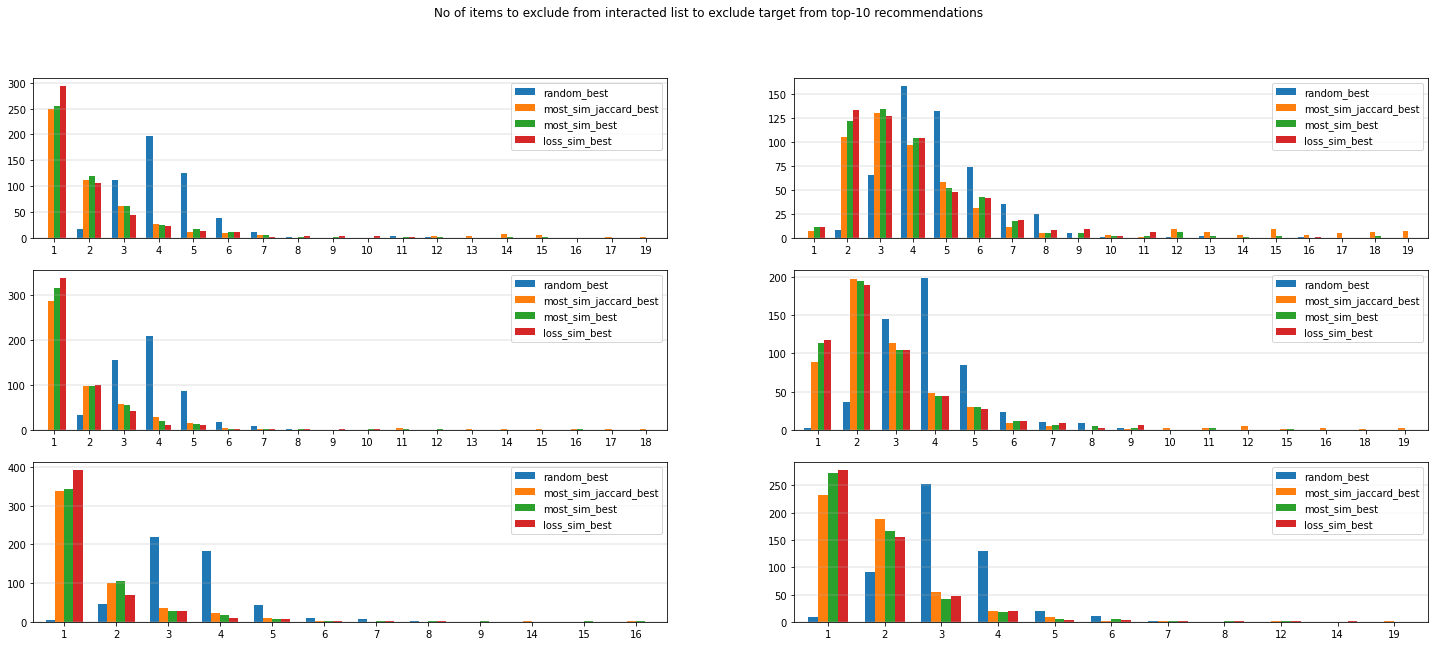

In [298]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'most_sim_jaccard_init': cnt[pos][f'jaccard_{col}'][0],
#             'most_sim_init': cnt[pos][f'most_sim_{col}'][0],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'most_sim_jaccard_best': cnt[pos][f'jaccard_{col}'][1],
            'most_sim_best': cnt[pos][f'most_sim_{col}'][1],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1]
        }, orient='columns')
        df.sort_index().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('No of items to exclude from interacted list to exclude target from top-10 recommendations')

In [286]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)

for i in range(2):
    cnt, no_target_achieved_cases = convert_res_to_lists(random_cfs[i], cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(most_sim_cfs[i], cnt, no_target_achieved_cases, f'most_sim_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(most_sim_jaccard_cfs[i], cnt, no_target_achieved_cases, f'jaccard_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'yloss_{i}')

Text(0.5, 0.98, 'No of items to exclude from interacted list to exclude target from top-10 recommendations')

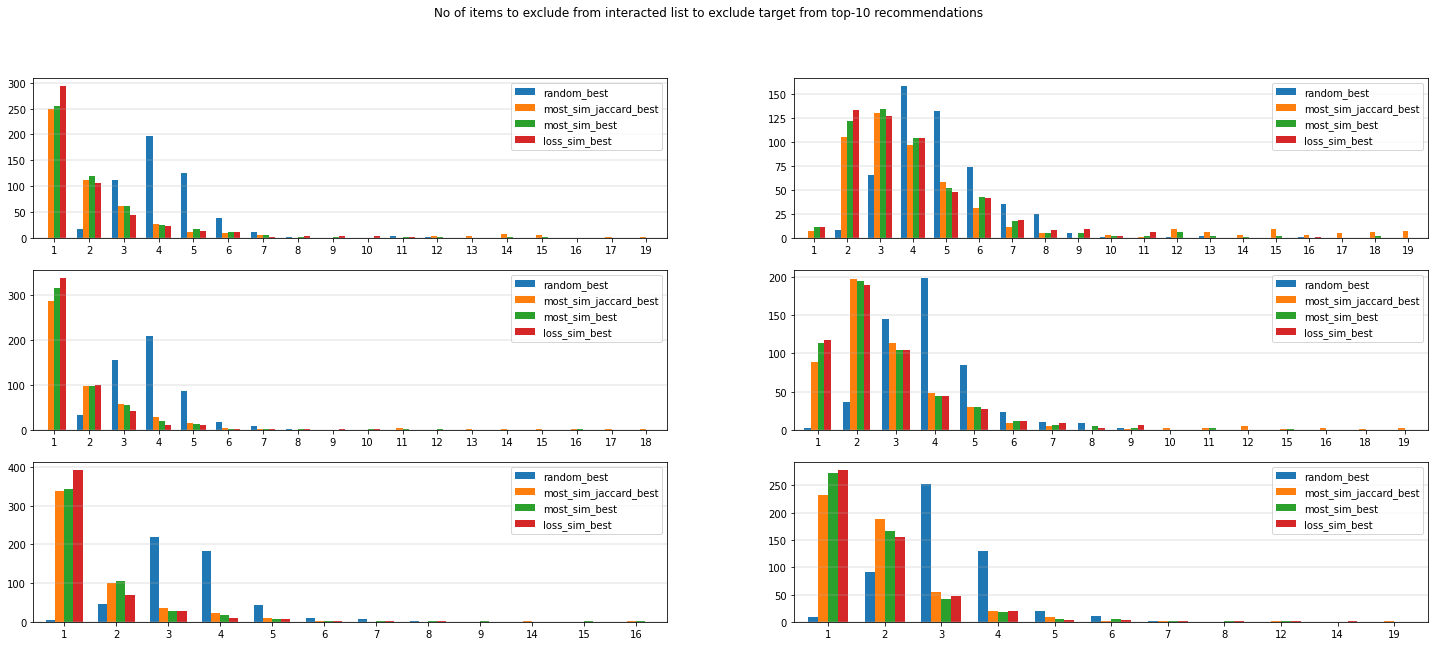

In [298]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'most_sim_jaccard_init': cnt[pos][f'jaccard_{col}'][0],
#             'most_sim_init': cnt[pos][f'most_sim_{col}'][0],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'most_sim_jaccard_best': cnt[pos][f'jaccard_{col}'][1],
            'most_sim_best': cnt[pos][f'most_sim_{col}'][1],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1]
        }, orient='columns')
        df.sort_index().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('No of items to exclude from interacted list to exclude target from top-10 recommendations')

Text(0.5, 0.98, 'Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

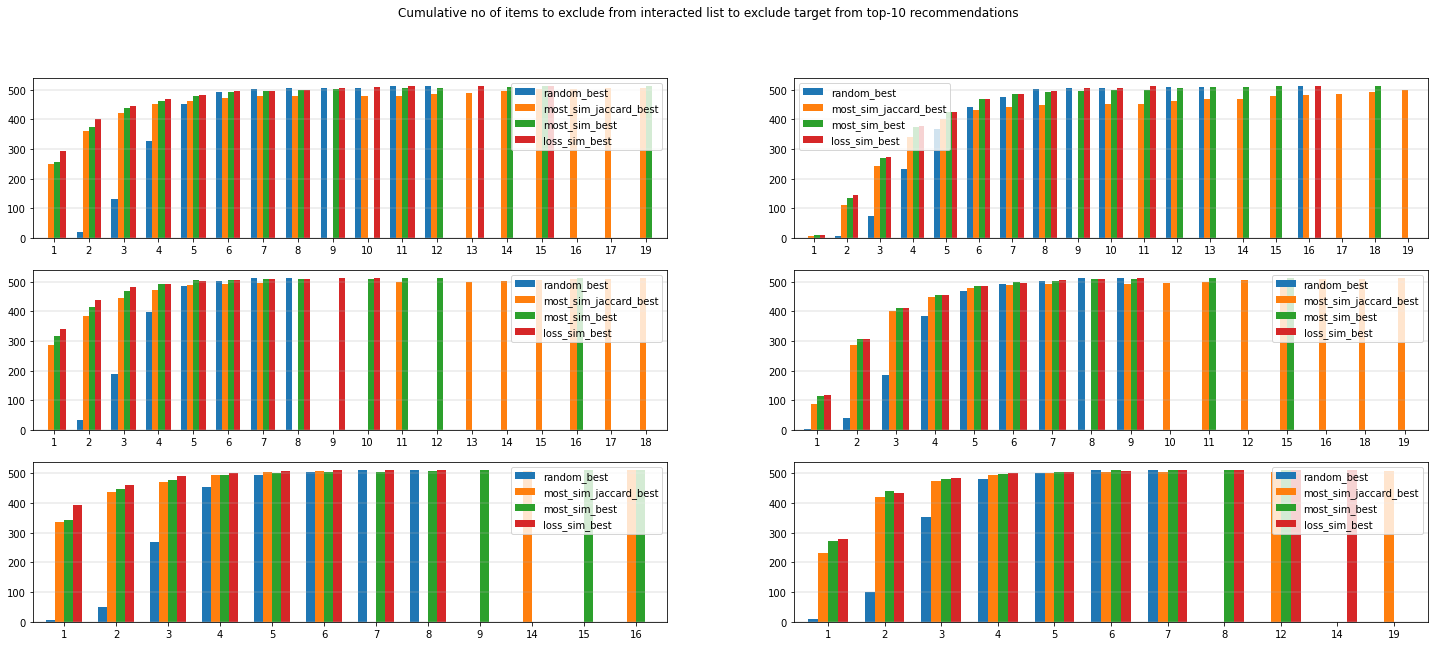

In [297]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'most_sim_jaccard_init': cnt[pos][f'jaccard_{col}'][0],
#             'most_sim_init': cnt[pos][f'most_sim_{col}'][0],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'most_sim_jaccard_best': cnt[pos][f'jaccard_{col}'][1],
            'most_sim_best': cnt[pos][f'most_sim_{col}'][1],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1]
        }, orient='columns')
        df.sort_index().cumsum().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

## Distribution of budget consumption

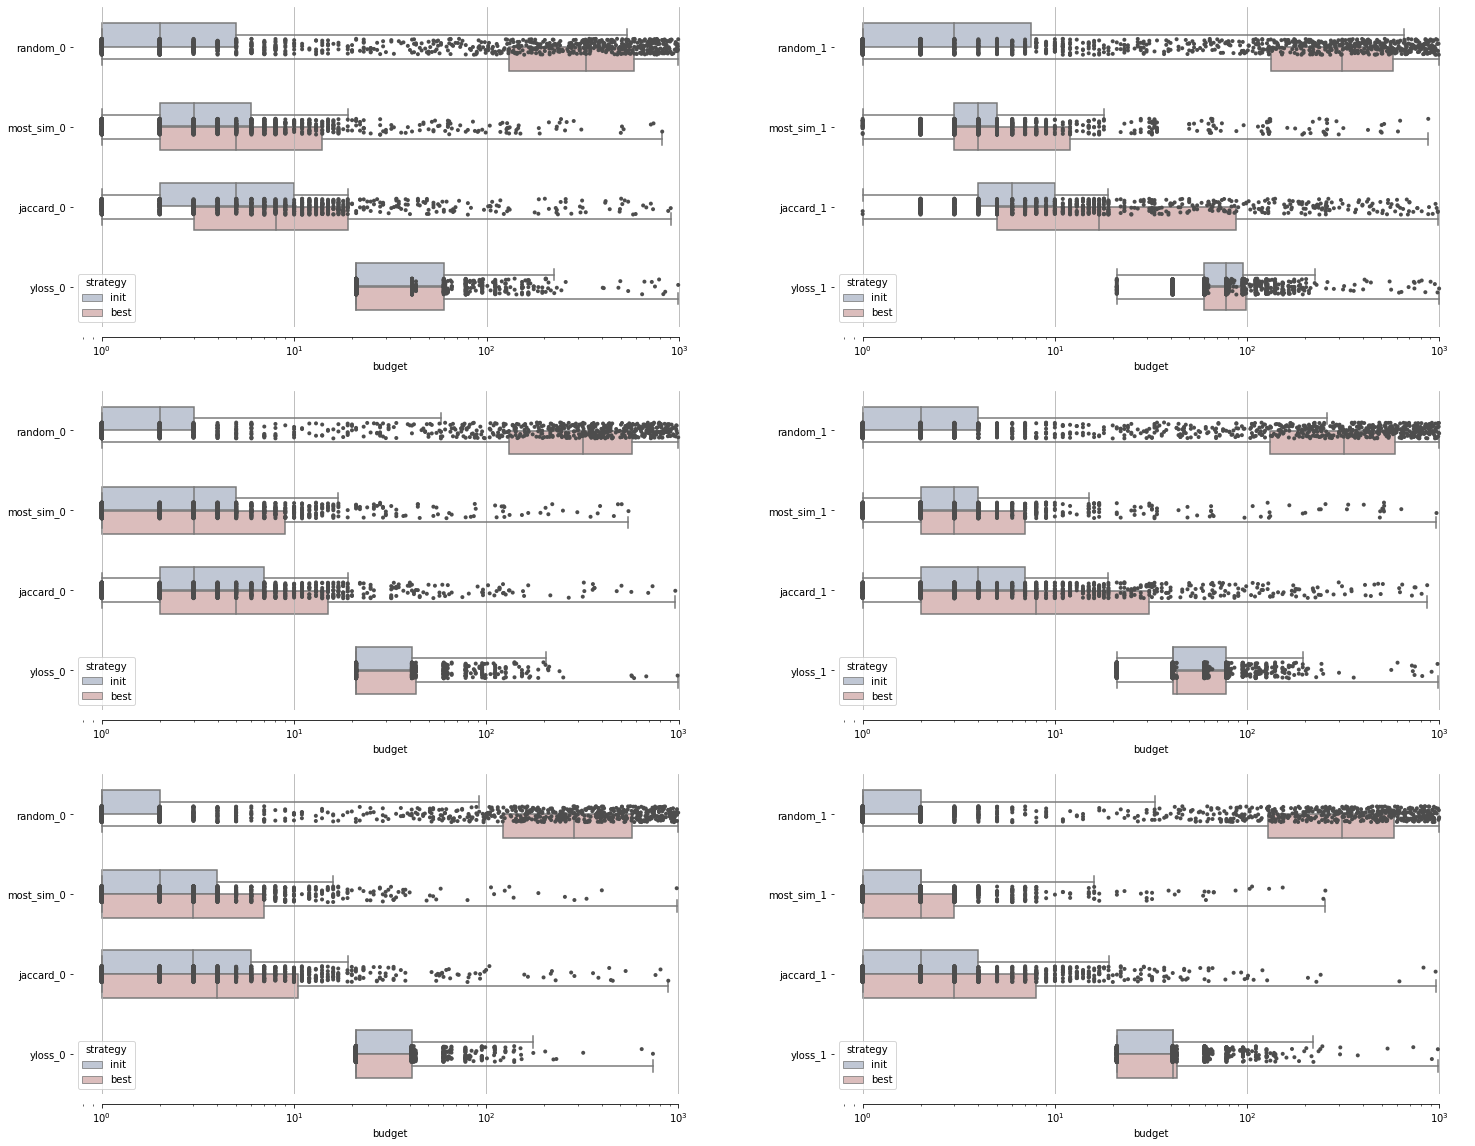

In [303]:
# sns.set_theme(style="ticks")
# pos = [2, 3]
strategies = [('init', 2), ('best', 3)]
# pos = [2]
# strategies = ['init']
cnames = ['method', 'strategy', 'budget']

# Initialize the figure with a logarithmic x axis
# f, ax = plt.subplots(3, 1, figsize=(20, 20))
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 20))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):

        df = pd.DataFrame.from_records(
            list(itertools.chain(*(
                zip(itertools.repeat(k), itertools.repeat(t[0]), v[t[1]])
                for k, v in cnt[pos].items() if f'_{col}' in k
                for t in strategies
            ))), columns=cnames
        )

        # Plot the orbital period with horizontal boxes
        sns.boxplot(x='budget', y='method', hue='strategy', data=df,
                    whis=[0, 100], width=.6, palette="vlag", ax=axs[row][col])

        # Add in points to show each observation
        sns.stripplot(x='budget', y='method', data=df,
                      size=4, color=".3", linewidth=0, ax=axs[row][col])


        # Tweak the visual presentation
        axs[row][col].set_xscale("log")
        axs[row][col].xaxis.grid(True)
        axs[row][col].set(ylabel="")

sns.despine(trim=True, offset=10, left=True)

## Randomized pick of candidates of interaction lists in lattice

In [34]:
random_most_sim_cfs = _find_cfs(test, pooling_model, [3, 5, 7], no_users=500, backend='random_most_sim', init_budget=1000)
random_yloss_sim_cfs = _find_cfs(test, pooling_model, [3, 5, 7], no_users=500, backend='random_loss_sim', init_budget=1000)

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:52,  2.61s/it]              

target position loop: 30it [01:07,  2.29s/it]

target position loop: 30it [01:14,  2.49s/it]
target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:25,  1.25s/it]              

target position loop: 30it [00:40,  1.35s/it]

target position loop: 30it [00:51,  1.73s/it]


In [38]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)

cnt, no_target_achieved_cases = convert_res_to_lists(random_cfs, cnt, no_target_achieved_cases, 'random')
cnt, no_target_achieved_cases = convert_res_to_lists(most_sim_cfs, cnt, no_target_achieved_cases, 'most_sim')
cnt, no_target_achieved_cases = convert_res_to_lists(yloss_sim_cfs, cnt, no_target_achieved_cases, 'yloss')
cnt, no_target_achieved_cases = convert_res_to_lists(random_most_sim_cfs, cnt, no_target_achieved_cases, 'random_most_sim')
cnt, no_target_achieved_cases = convert_res_to_lists(random_yloss_sim_cfs, cnt, no_target_achieved_cases, 'random_yloss')

Text(0.5, 0.98, 'No of items to exclude from interacted list to exclude target from top-10 recommendations')

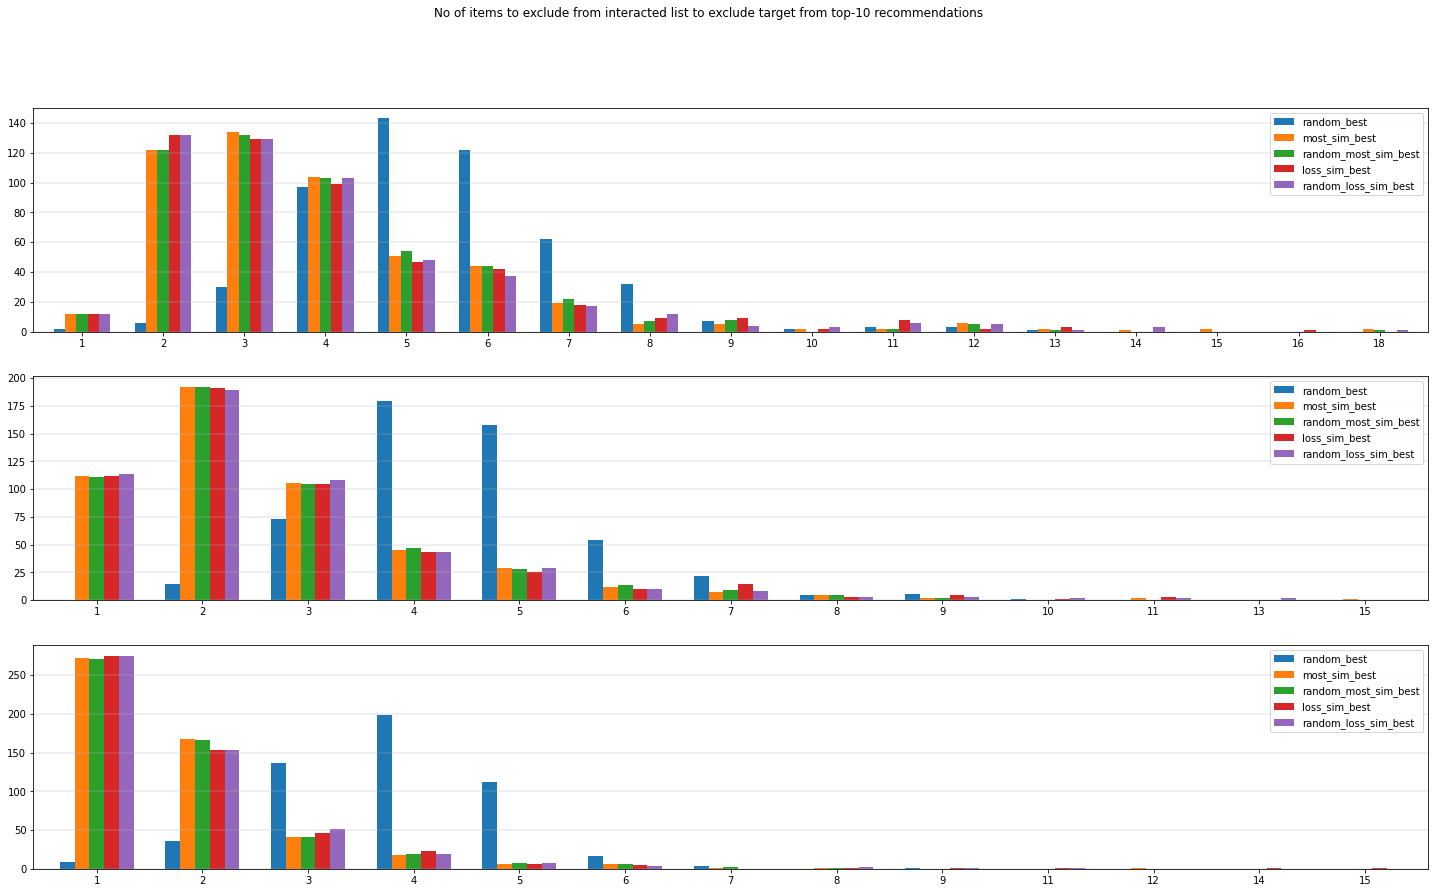

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(25, 14))

df = pd.DataFrame.from_dict({
    'random_best': cnt[3]['random'][1],
    'most_sim_best': cnt[3]['most_sim'][1],
    'random_most_sim_best': cnt[3]['random_most_sim'][1],
    'loss_sim_best': cnt[3]['yloss'][1],
    'random_loss_sim_best': cnt[3]['random_yloss'][1],
}, orient='columns')
df.sort_index().plot.bar(ax=axs[0], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

df = pd.DataFrame.from_dict({
    'random_best': cnt[5]['random'][1],   
    'most_sim_best': cnt[5]['most_sim'][1],
    'random_most_sim_best': cnt[5]['random_most_sim'][1],
    'loss_sim_best': cnt[5]['yloss'][1],
    'random_loss_sim_best': cnt[5]['random_yloss'][1],
}, orient='columns')
# df.sort_index().plot.bar(y=['most_sim_init', 'most_sim_best', 'random_best'], ax=axs[1], rot=0)
df.sort_index().plot.bar(ax=axs[1], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

df = pd.DataFrame.from_dict({
    'random_best': cnt[7]['random'][1],
    'most_sim_best': cnt[7]['most_sim'][1],
    'random_most_sim_best': cnt[7]['random_most_sim'][1],
    'loss_sim_best': cnt[7]['yloss'][1],
    'random_loss_sim_best': cnt[7]['random_yloss'][1],
}, orient='columns')
df.sort_index().plot.bar(ax=axs[2], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('No of items to exclude from interacted list to exclude target from top-10 recommendations')

Text(0.5, 0.98, 'Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

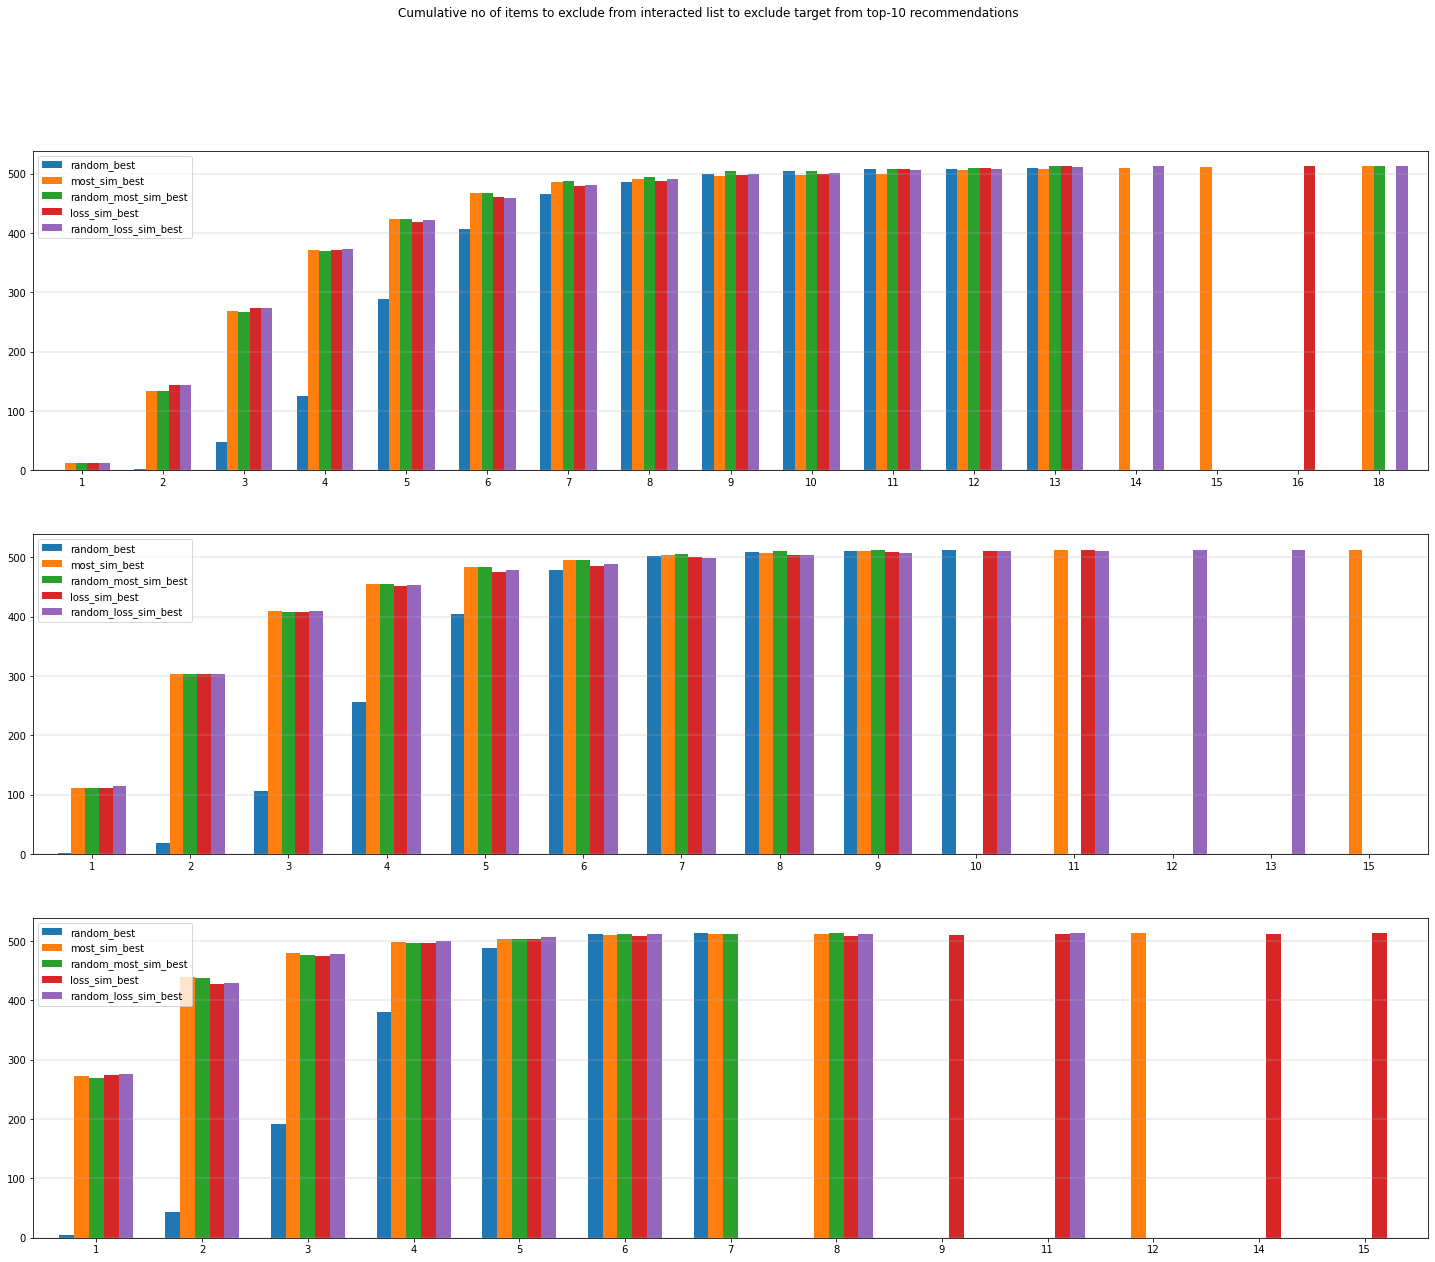

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(25, 20))

df = pd.DataFrame.from_dict({
    'random_best': cnt[3]['random'][1],    
    'most_sim_best': cnt[3]['most_sim'][1],
    'random_most_sim_best': cnt[3]['random_most_sim'][1],
    'loss_sim_best': cnt[3]['yloss'][1],
    'random_loss_sim_best': cnt[3]['random_yloss'][1],
}, orient='columns')
df.sort_index().cumsum().plot.bar(ax=axs[0], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

df = pd.DataFrame.from_dict({
    'random_best': cnt[5]['random'][1],
    'most_sim_best': cnt[5]['most_sim'][1],
    'random_most_sim_best': cnt[5]['random_most_sim'][1],
    'loss_sim_best': cnt[5]['yloss'][1],
    'random_loss_sim_best': cnt[5]['random_yloss'][1],
}, orient='columns')
df.sort_index().cumsum().plot.bar(ax=axs[1], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

df = pd.DataFrame.from_dict({
   'random_best': cnt[7]['random'][1],
    'most_sim_best': cnt[7]['most_sim'][1],
    'random_most_sim_best': cnt[7]['random_most_sim'][1],
    'loss_sim_best': cnt[7]['yloss'][1],
    'random_loss_sim_best': cnt[7]['random_yloss'][1],
}, orient='columns')
df.sort_index().cumsum().plot.bar(ax=axs[2], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

## DFS search and fix ordering of excluding interacted items based on target's yloss

In [341]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)

for i in range(2):
    cnt, no_target_achieved_cases = convert_res_to_lists(random_cfs[i], cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'yloss_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(fixed_yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'fixed_yloss_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(dfs_yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'dfs_yloss_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(dfs_fixed_yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'dfs_fixed_yloss_{i}')

Text(0.5, 0.98, 'No of items to exclude from interacted list to exclude target from top-10 recommendations')

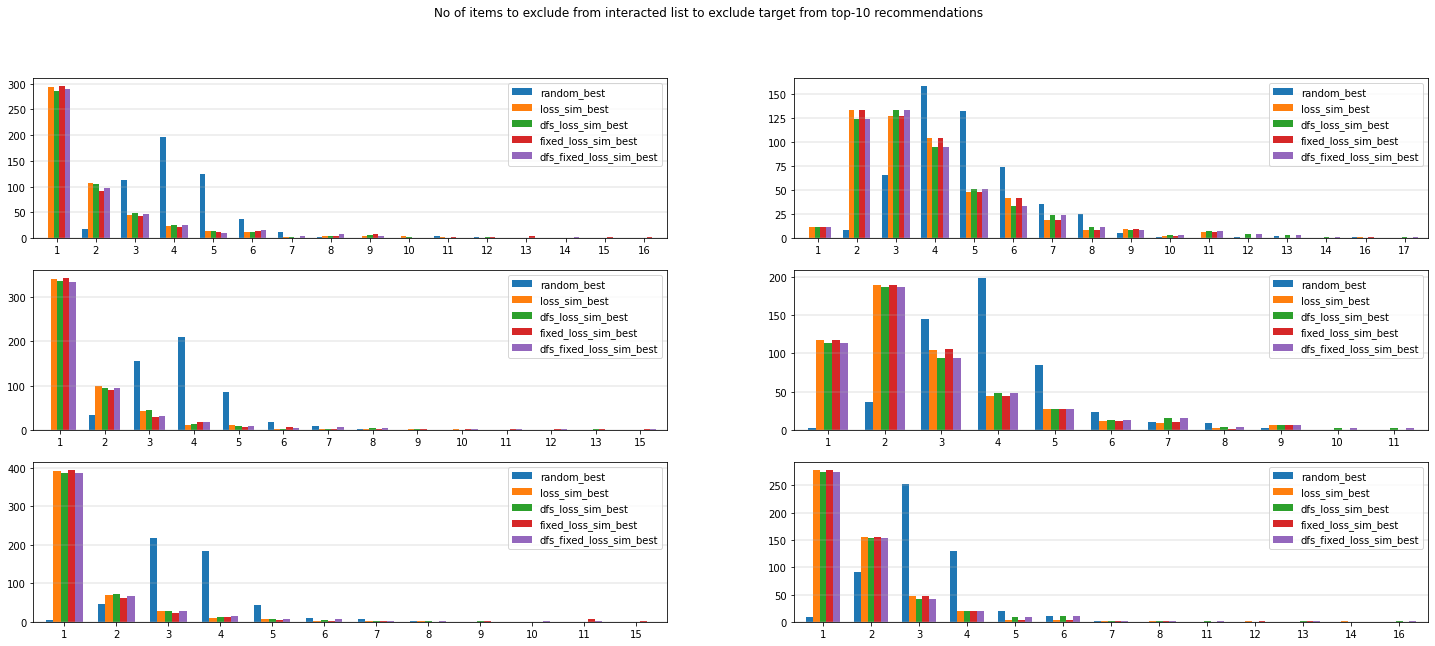

In [342]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1],
        #     'dfs_loss_sim_init': cnt[3]['dfs_yloss'][0],
            'dfs_loss_sim_best': cnt[pos][f'dfs_yloss_{col}'][1],
#             'fixed_loss_sim_init': cnt[pos][f'fixed_yloss_{col}'][0],
            'fixed_loss_sim_best': cnt[pos][f'fixed_yloss_{col}'][1],
        #     'dfs_fixed_loss_sim_init': cnt[3]['dfs_fixed_yloss'][0],
            'dfs_fixed_loss_sim_best': cnt[pos][f'dfs_fixed_yloss_{col}'][1],
        }, orient='columns')
        df.sort_index().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('No of items to exclude from interacted list to exclude target from top-10 recommendations')

Text(0.5, 0.98, 'Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

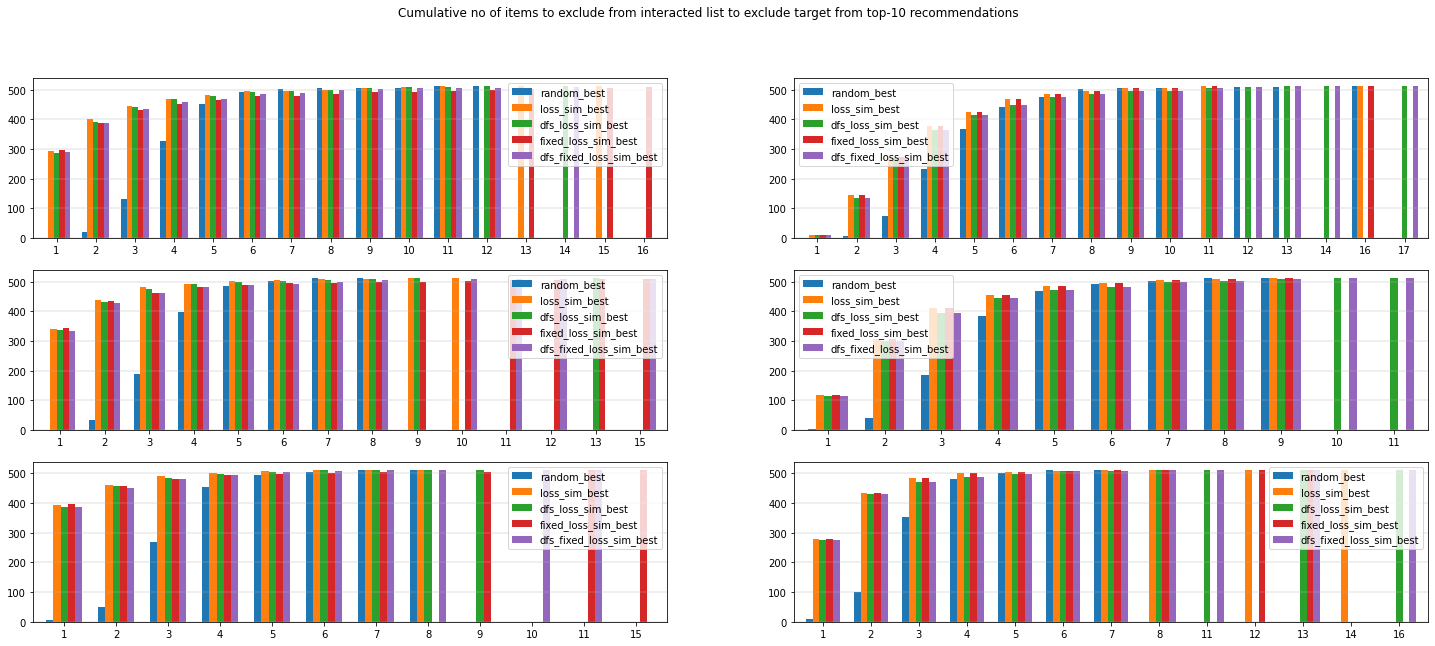

In [343]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1],
            'dfs_loss_sim_best': cnt[pos][f'dfs_yloss_{col}'][1],
#             'fixed_loss_sim_init': cnt[pos][f'fixed_yloss_{col}'][0],
            'fixed_loss_sim_best': cnt[pos][f'fixed_yloss_{col}'][1],
        #     'dfs_fixed_loss_sim_init': cnt[3]['dfs_fixed_yloss'][0],
            'dfs_fixed_loss_sim_best': cnt[pos][f'dfs_fixed_yloss_{col}'][1],
        }, orient='columns')
        df.sort_index().cumsum().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

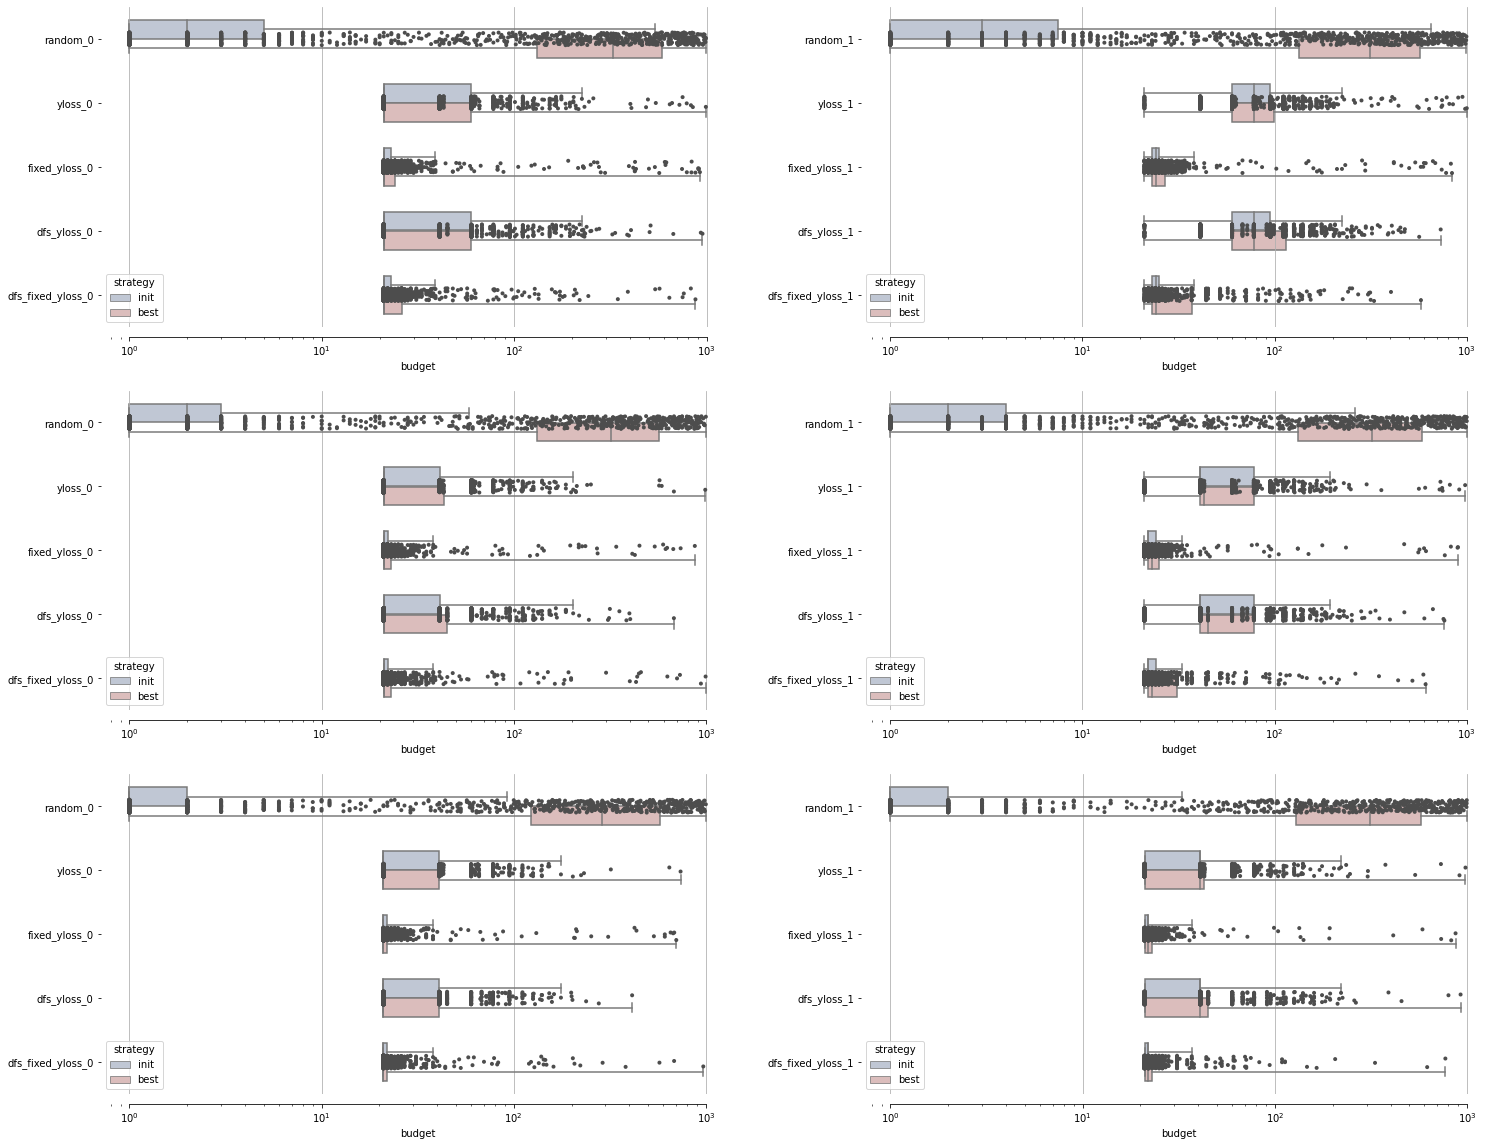

In [327]:
# sns.set_theme(style="ticks")
strategies = [('init', 2), ('best', 3)]
# pos = [2]
# strategies = ['init']
cnames = ['method', 'strategy', 'budget']

# Initialize the figure with a logarithmic x axis
# f, ax = plt.subplots(3, 1, figsize=(20, 20))
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 20))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):

        df = pd.DataFrame.from_records(
            list(itertools.chain(*(
                zip(itertools.repeat(k), itertools.repeat(t[0]), v[t[1]])
                for k, v in cnt[pos].items() if f'_{col}' in k
                for t in strategies
            ))), columns=cnames
        )

        # Plot the orbital period with horizontal boxes
        sns.boxplot(x='budget', y='method', hue='strategy', data=df,
                    whis=[0, 100], width=.6, palette="vlag", ax=axs[row][col])

        # Add in points to show each observation
        sns.stripplot(x='budget', y='method', data=df,
                      size=4, color=".3", linewidth=0, ax=axs[row][col])

        # Tweak the visual presentation
        axs[row][col].set_xscale("log")
        axs[row][col].xaxis.grid(True)
        axs[row][col].set(ylabel="")

sns.despine(trim=True, offset=10, left=True)

## Best First Searching

In [328]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)

for i in range(2):
    cnt, no_target_achieved_cases = convert_res_to_lists(random_cfs[i], cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'yloss_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(bestfs_yloss_cfs[i], cnt, no_target_achieved_cases, f'bestFS_yloss_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(bestfs_fixed_yloss_cfs[i], cnt, no_target_achieved_cases, f'bestFS_fixed_yloss_{i}')

Text(0.5, 0.98, 'No of items to exclude from interacted list to exclude target from top-10 recommendations')

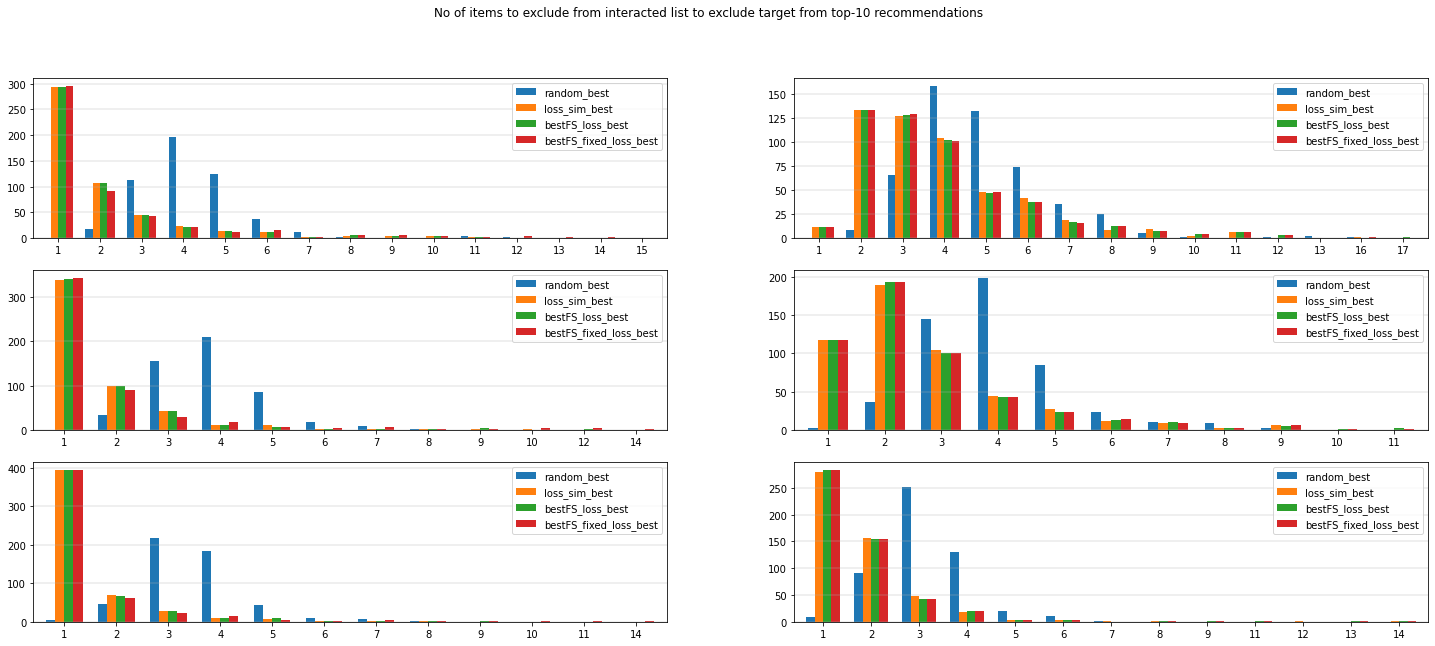

In [318]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1],
#             'bestFS_loss_init': cnt[pos][f'bestFS_yloss_{col}'][0],
            'bestFS_loss_best': cnt[pos][f'bestFS_yloss_{col}'][1],
#             'bestFS_fixed_loss_init': cnt[pos][f'bestFS_fixed_yloss_{col}'][0],
            'bestFS_fixed_loss_best': cnt[pos][f'bestFS_fixed_yloss_{col}'][1],
        }, orient='columns')
        df.sort_index().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('No of items to exclude from interacted list to exclude target from top-10 recommendations')

Text(0.5, 0.98, 'Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

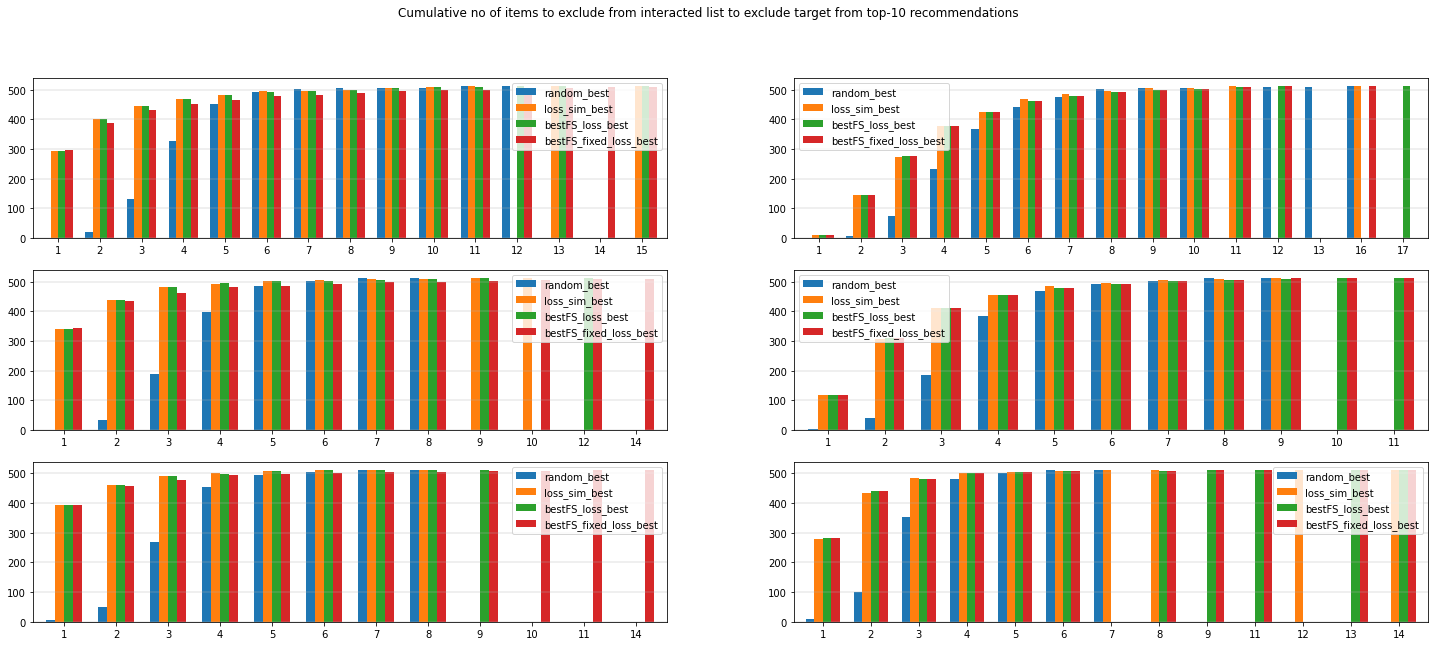

In [319]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):

        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1],
#             'bestFS_loss_init': cnt[pos][f'bestFS_yloss_{col}'][0],
            'bestFS_loss_best': cnt[pos][f'bestFS_yloss_{col}'][1],
#             'bestFS_fixed_loss_init': cnt[pos][f'bestFS_fixed_yloss_{col}'][0],
            'bestFS_fixed_loss_best': cnt[pos][f'bestFS_fixed_yloss_{col}'][1],
        }, orient='columns')
        df.sort_index().cumsum().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

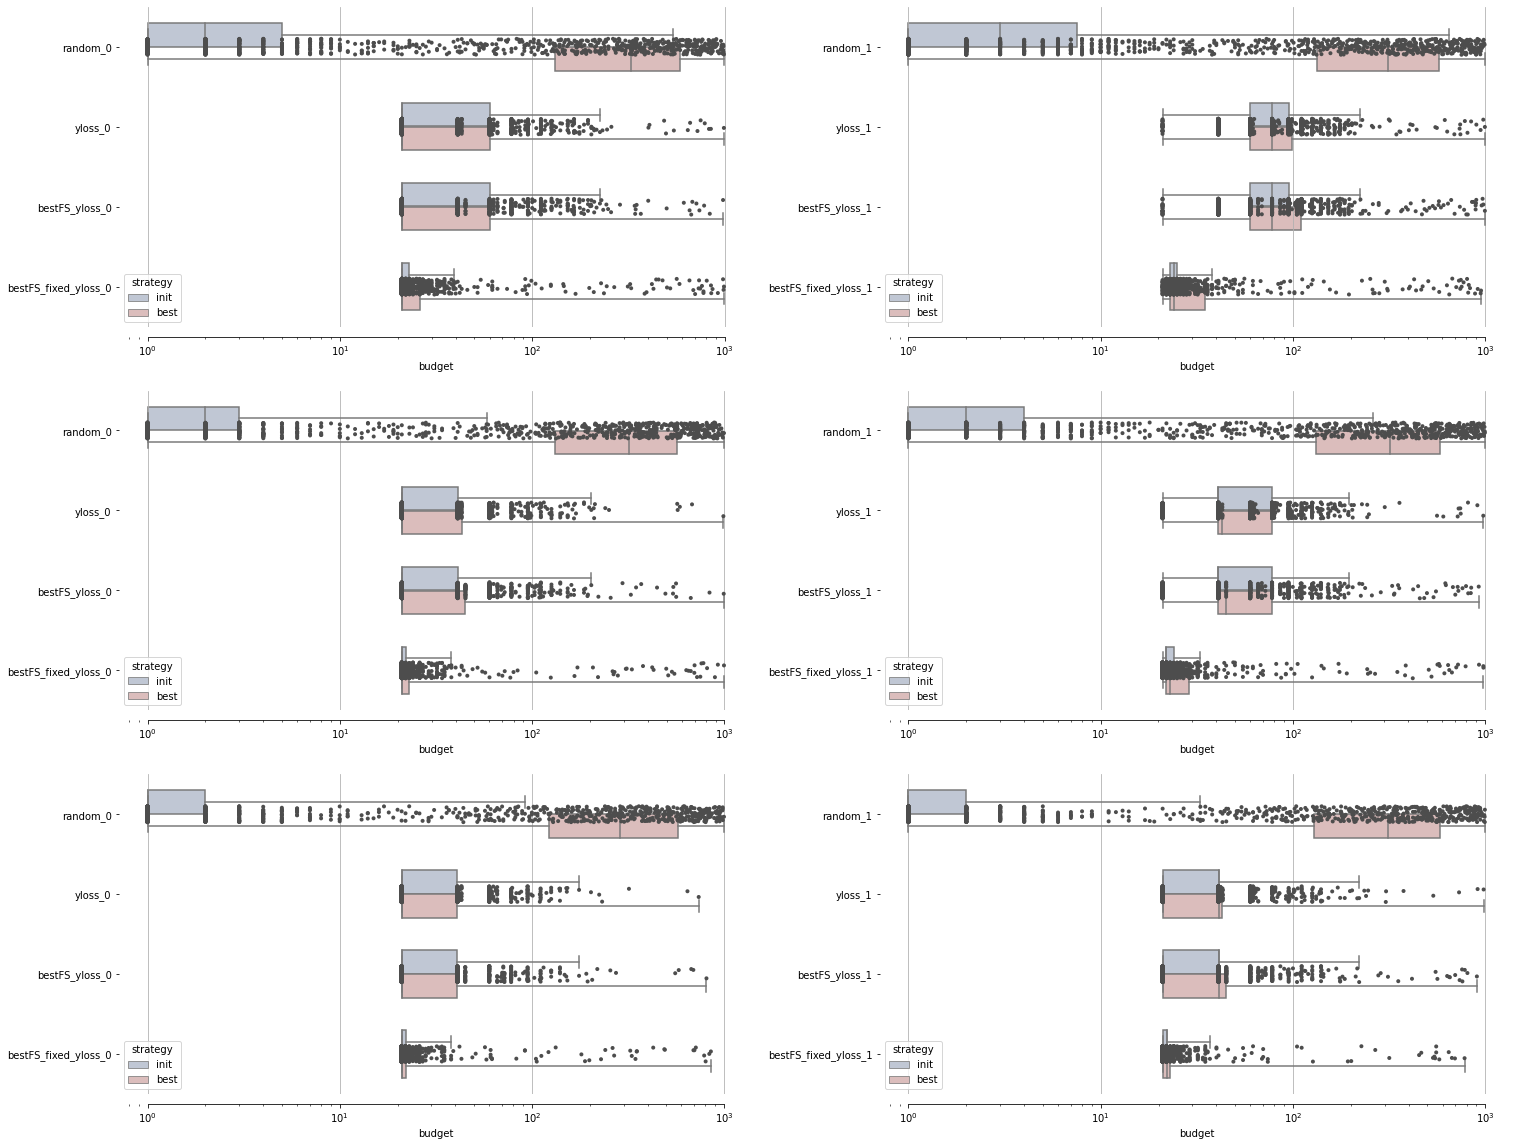

In [329]:
# sns.set_theme(style="ticks")
strategies = [('init', 2), ('best', 3)]
# pos = [2]
# strategies = ['init']
cnames = ['method', 'strategy', 'budget']

# Initialize the figure with a logarithmic x axis
# f, ax = plt.subplots(3, 1, figsize=(20, 20))
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 20))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):

        df = pd.DataFrame.from_records(
            list(itertools.chain(*(
                zip(itertools.repeat(k), itertools.repeat(t[0]), v[t[1]])
                for k, v in cnt[pos].items() if f'_{col}' in k
                for t in strategies
            ))), columns=cnames
        )

        # Plot the orbital period with horizontal boxes
        sns.boxplot(x='budget', y='method', hue='strategy', data=df,
                    whis=[0, 100], width=.6, palette="vlag", ax=axs[row][col])

        # Add in points to show each observation
        sns.stripplot(x='budget', y='method', data=df,
                      size=4, color=".3", linewidth=0, ax=axs[row][col])


        # Tweak the visual presentation
        axs[row][col].set_xscale("log")
        axs[row][col].xaxis.grid(True)
        axs[row][col].set(ylabel="")

# ------------------------------------------------------------

sns.despine(trim=True, offset=10, left=True)

## Top Down Searching

In [330]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)

for i in range(2):
    cnt, no_target_achieved_cases = convert_res_to_lists(random_cfs[i], cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(yloss_sim_cfs[i], cnt, no_target_achieved_cases, f'yloss_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(topdown_bestfs_yloss_cfs[i], cnt, no_target_achieved_cases, f'topdown_yloss_{i}')

Text(0.5, 0.98, 'No of items to exclude from interacted list to exclude target from top-10 recommendations')

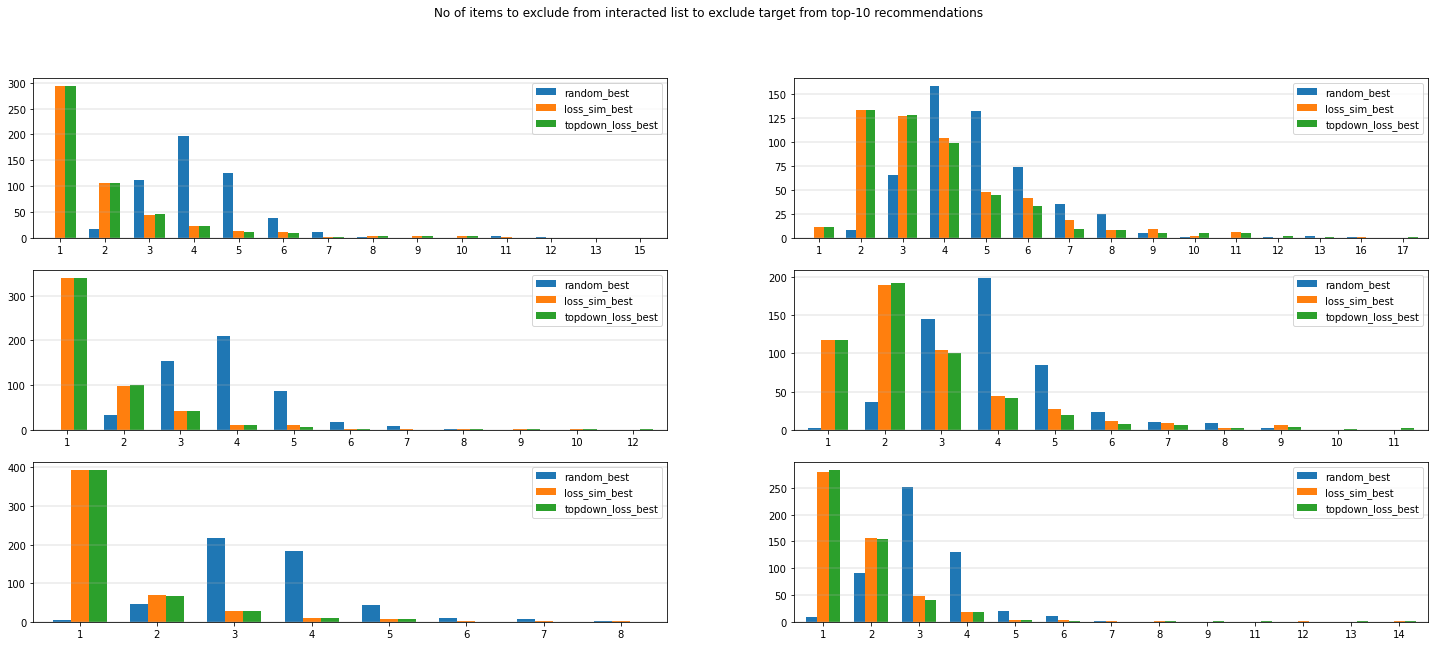

In [331]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1],
#             'topdown_loss_init': cnt[pos][f'topdown_yloss_{col}'][0],
            'topdown_loss_best': cnt[pos][f'topdown_yloss_{col}'][1],
        }, orient='columns')
        df.sort_index().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('No of items to exclude from interacted list to exclude target from top-10 recommendations')

Text(0.5, 0.98, 'Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

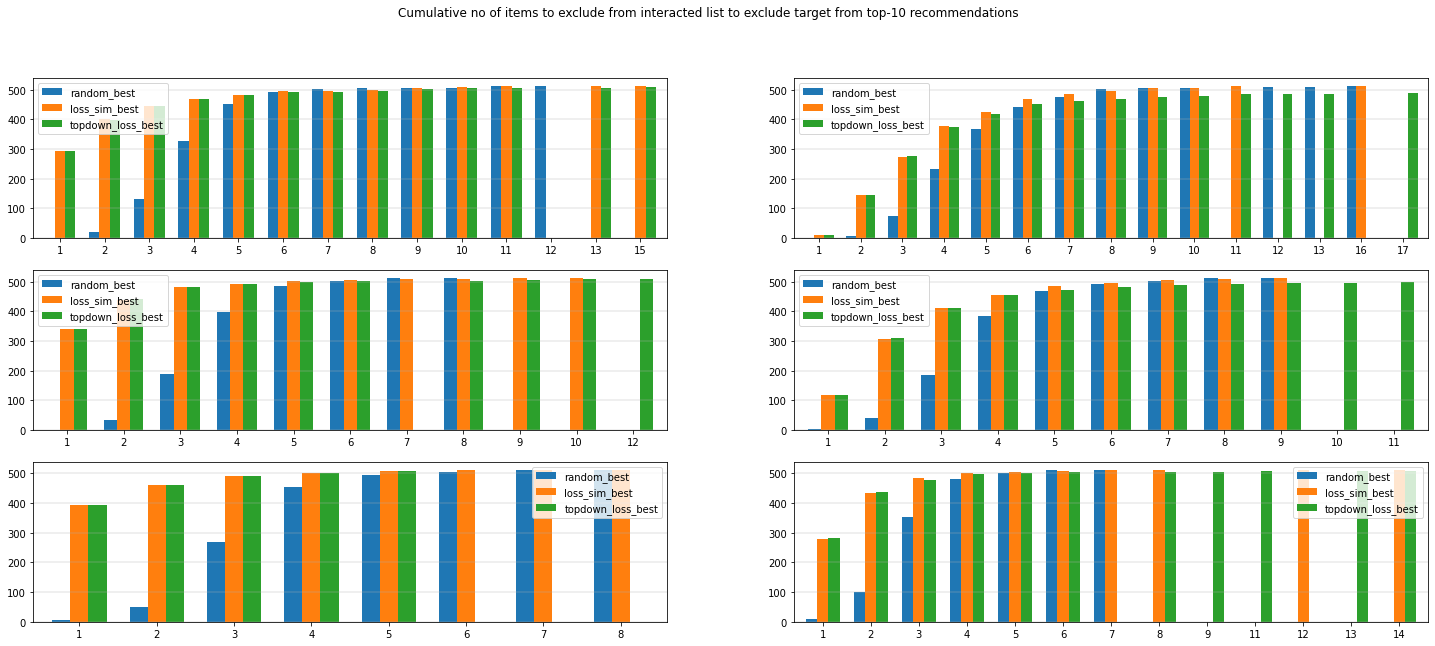

In [334]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 10))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):

        df = pd.DataFrame.from_dict({
            'random_best': cnt[pos][f'random_{col}'][1],
#             'loss_sim_init': cnt[pos][f'yloss_{col}'][0],
            'loss_sim_best': cnt[pos][f'yloss_{col}'][1],
#             'topdown_loss_init': cnt[pos][f'topdown_yloss_{col}'][0],
            'topdown_loss_best': cnt[pos][f'topdown_yloss_{col}'][1],
        }, orient='columns')
        df.sort_index().cumsum().plot.bar(ax=axs[row][col], rot=0, width=0.7).grid(axis='y', linewidth=0.4)

plt.suptitle('Cumulative no of items to exclude from interacted list to exclude target from top-10 recommendations')

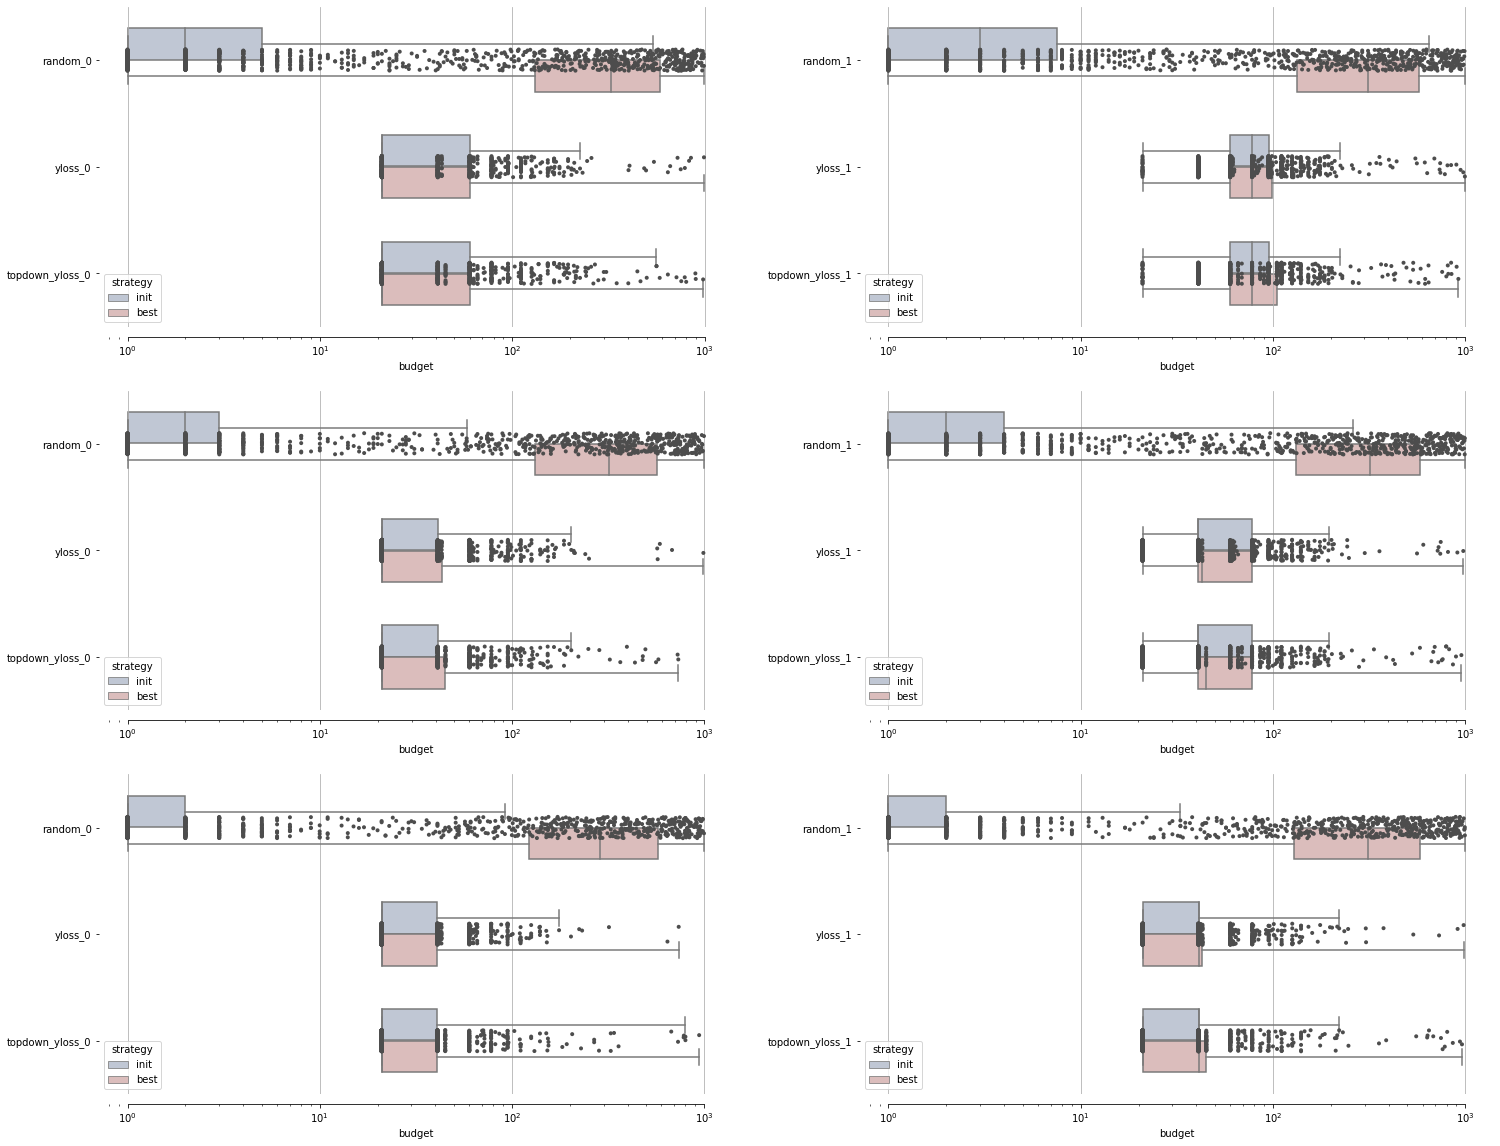

In [336]:
# sns.set_theme(style="ticks")

strategies = [('init', 2), ('best', 3)]
# pos = [2]
# strategies = ['init']
cnames = ['method', 'strategy', 'budget']

# Initialize the figure with a logarithmic x axis
# f, ax = plt.subplots(3, 1, figsize=(20, 20))
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(25, 20))

for col in range(cols):
    for pos, row in zip([3, 5, 7], range(rows)):
        df = pd.DataFrame.from_records(
            list(itertools.chain(*(
                zip(itertools.repeat(k), itertools.repeat(t[0]), v[t[1]])
                for k, v in cnt[pos].items() if f'_{col}' in k
                for t in strategies
            ))), columns=cnames
        )

        # Plot the orbital period with horizontal boxes
        sns.boxplot(x='budget', y='method', hue='strategy', data=df,
                    whis=[0, 100], width=.6, palette="vlag", ax=axs[row][col])

        # Add in points to show each observation
        sns.stripplot(x='budget', y='method', data=df,
                      size=4, color=".3", linewidth=0, ax=axs[row][col])


        # Tweak the visual presentation
        axs[row][col].set_xscale("log")
        axs[row][col].xaxis.grid(True)
        axs[row][col].set(ylabel="")

# ------------------------------------------------------------

sns.despine(trim=True, offset=10, left=True)

In [112]:
from collections import Counter


cnt = dict.fromkeys(yloss_sim_cfs.keys())
non_solvable_cases = dict.fromkeys(yloss_sim_cfs.keys())
counter = dict.fromkeys(yloss_sim_cfs.keys())
for key, values in yloss_sim_cfs.items():
    cnt[key] = []
    non_solvable_cases[key] = []
    counter[key] = 0

    total_data = []
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10:
                non_solvable_cases[key].append(rec.user_id)
                total_data.append(rec.pos)

            counter[key] += 1

    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'Percentage of satisfied constraints')

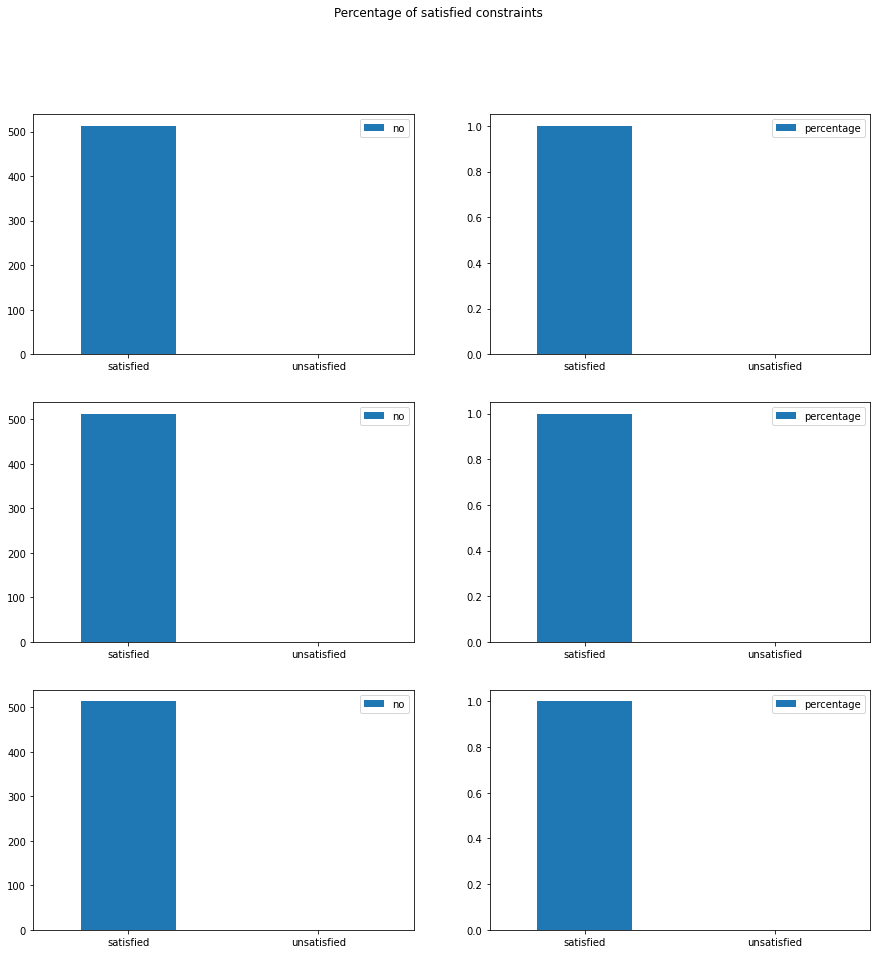

In [113]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))


df = pd.DataFrame([counter[3] - len(non_solvable_cases[3]), len(non_solvable_cases[3])],
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame([counter[5] - len(non_solvable_cases[5]), len(non_solvable_cases[5])],
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame([counter[7] - len(non_solvable_cases[7]), len(non_solvable_cases[7])],
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Percentage of satisfied constraints')

Text(0.5, 0.98, 'Position of not achieved cases')

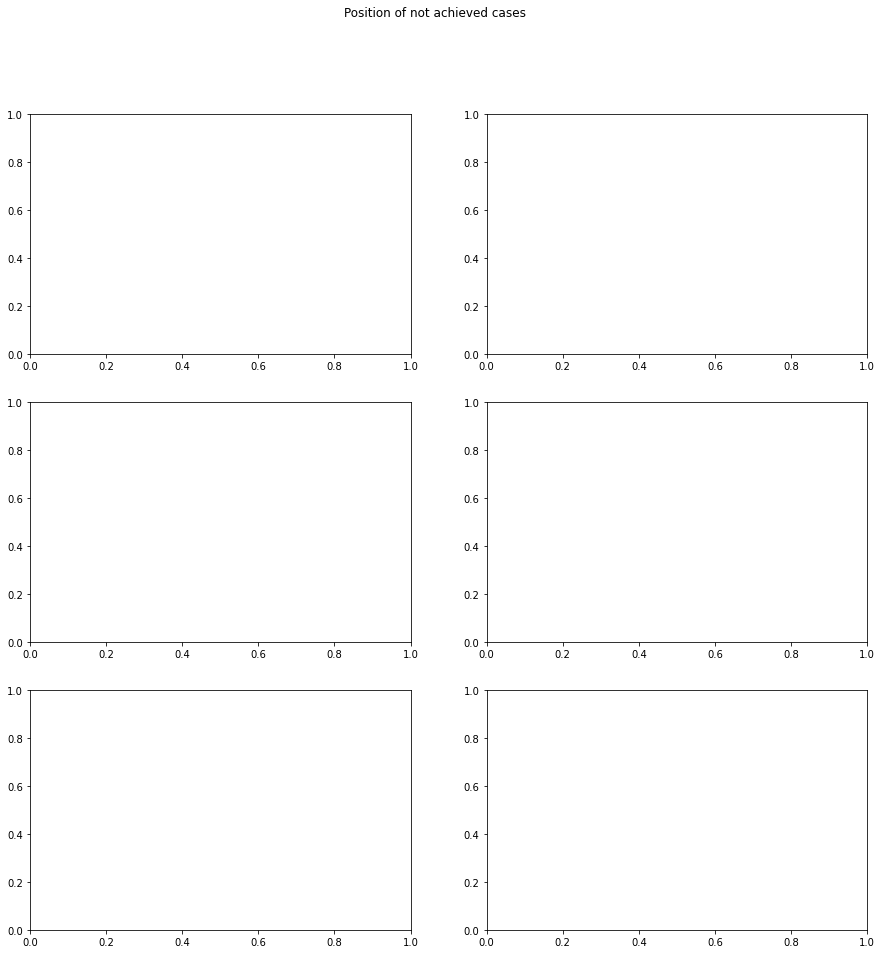

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

if cnt[3]:
    df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

if cnt[5]:
    df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

if cnt[7]:
    df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Position of not achieved cases')

In [32]:
dcts = [random_cfs, most_sim_cfs]
strategies = ['R', 'MSim']

dfs = [
    pd.DataFrame([[
        k, i.solution_found, i.iter_no['initial'], i.iter_no['best'], i.loss['initial'], i.loss['best'], i.cfs_dist, i.pos, s]
        for k, v in dct.items() for items in v for i in items if i is not None
    ]) for dct, s in zip(dcts, strategies)
]

cols = {'columns': {
    '0_x': f'init_target_pos_{strategies[0]}', '1_x': f'is_solved_{strategies[0]}',
    '2_x': f'init_iter_{strategies[0]}', '3_x': f'best_iter_{strategies[0]}',
    '4_x': f'init_loss_{strategies[0]}', '5_x': f'best_loss_{strategies[0]}',
    '6_x': f'iitems_del_{strategies[0]}', '7_x': f'f_target_pos_{strategies[0]}', '8_x': 'strategy',
    '0_y': f'init_target_pos_{strategies[1]}', '1_y': f'is_solved_{strategies[1]}',
    '2_y': f'init_iter_{strategies[1]}', '3_y': f'best_iter_{strategies[1]}',
    '4_y': f'init_loss_{strategies[1]}', '5_y': f'best_loss_{strategies[1]}',
    '6_y': f'iitems_del_{strategies[1]}', '7_y': f'f_target_pos_{strategies[1]}', '8_y': 'strategy'
}}
df = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True).reset_index().rename(**cols)

In [33]:
def plot_data(x, y, ax, title):
    # calculate the max values to annotate on the plot
    y_max = y.max()

    # find the index of the max value
    x_ind = np.where(y == y_max)

    # find the x based on the index of max
    x_max = x.iloc[x_ind]
    # ----------------------------------------------------------------------------------------------------
    # plot the data
    ax.plot(x, y, color = "black")
    ax.scatter(x_max, np.tile(y_max, len(x_max)), s = 300, color = "green", alpha = 0.3)

    # annotate the text of the Max value
#     ax.annotate(r'Max value',
#                  xy = (x_max, y_max),
#                  xytext = (-90, -50),
#                  textcoords = 'offset points',
#                  fontsize = 16,
#                  arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=.2")
#                )
    # ----------------------------------------------------------------------------------------------------
    # prettify the plot
    # fill the area with a specific color
    ax.fill_between(x, 0, y, where = 0 > y, facecolor='red', interpolate = True, alpha = 0.3)
    ax.fill_between(x, 0, y, where = 0 <= y, facecolor='green', interpolate = True, alpha = 0.3)

    # change the ylim to make it more pleasant for the viewer
    ax.set_ylim(y.min() * 1.1, y.max() * 1.1)

    # change the values of the x axis
    # extract the first 3 letters of the month
    # xtickvals = [str(m)[:3].upper() + "-" + str(y) for y,m in zip(df.date_converted.dt.year, df.date_converted.dt.month_name())]

    # this way we can set the ticks to be every 6 months.
    ax.set_xticks(x[::50])

    # change the current ticks to be our string month value
    # basically pass from this: 1967-07-01
    # to this: JUL-1967
    # ax.set_xticklabels(xtickvals[::6], rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

    # add a grid
    ax.grid(alpha = 0.3)

    # set the title
    # ax.set_title("Monthly variation return %");
    ax.set_title(title);

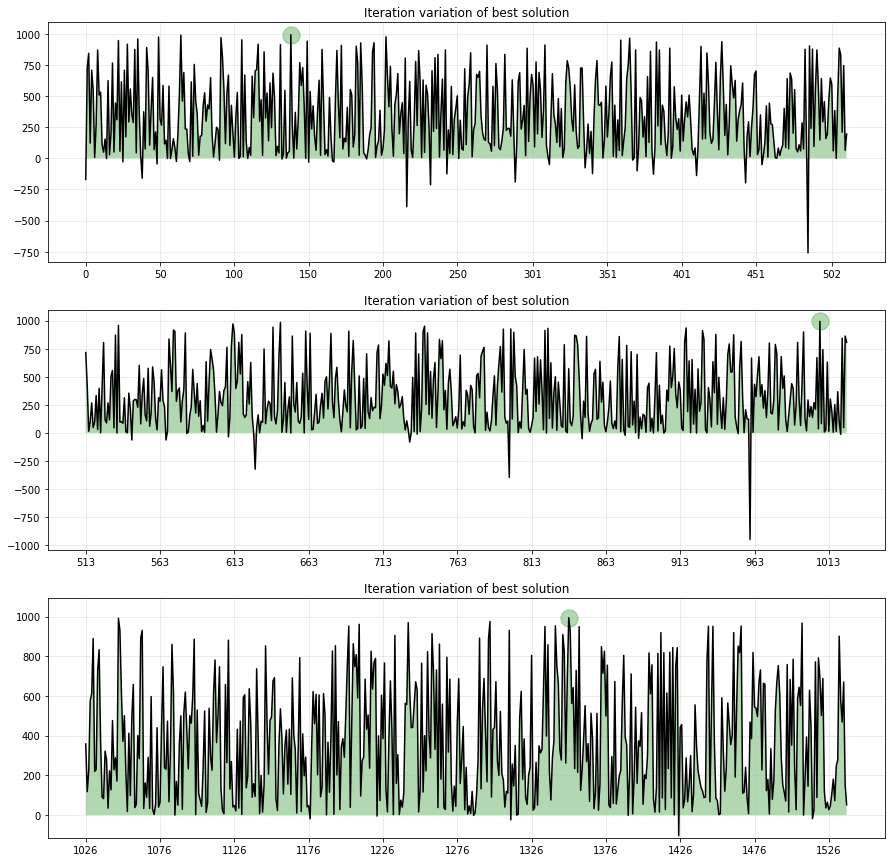

In [34]:
# instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["iter_diff"] = (df["best_iter_R"] - df["best_iter_MSim"])

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["iter_diff"]

plot_data(x, y, ax[0], "Iteration variation of best solution")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]
# del tmp_df['index']
# tmp_df.reset_index(inplace=True, drop=True)
# tmp_df.reset_index(inplace=True)

# separate x and y 
x = tmp_df['index']
y = tmp_df["iter_diff"]

plot_data(x, y, ax[1], "Iteration variation of best solution")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["iter_diff"]

plot_data(x, y, ax[2], "Iteration variation of best solution")

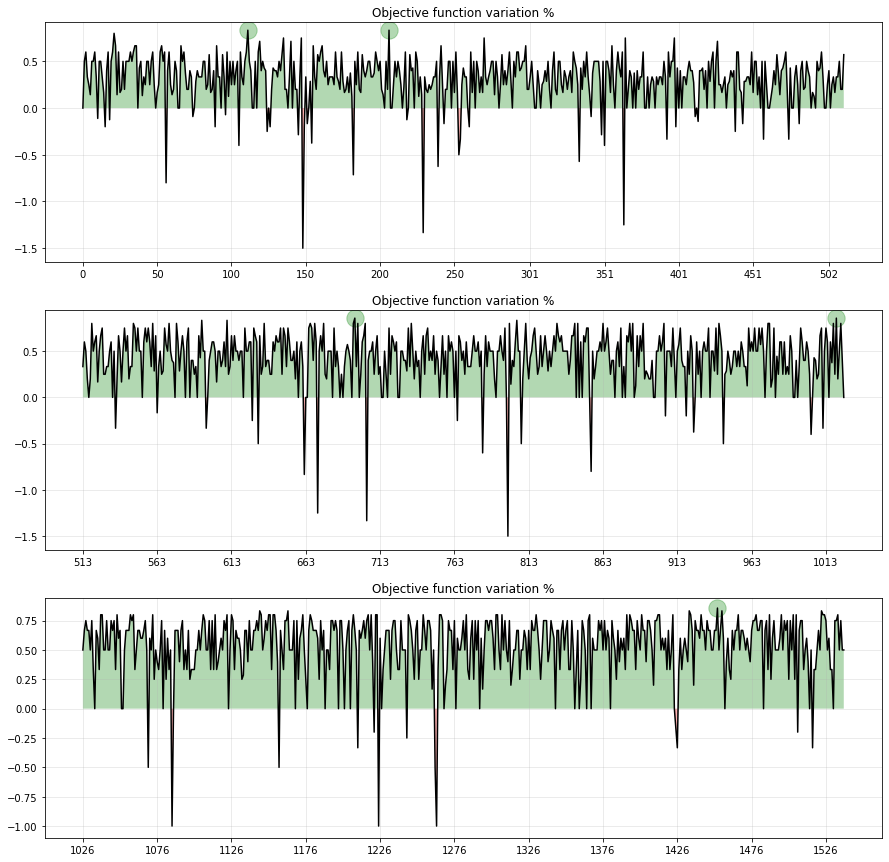

In [35]:
# # instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["loss_diff"] = (df["best_loss_R"] - df["best_loss_MSim"]) / df['best_loss_R']

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["loss_diff"]

plot_data(x, y, ax[0], "Objective function variation %")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["loss_diff"]

plot_data(x, y, ax[1], "Objective function variation %")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["loss_diff"]

plot_data(x, y, ax[2], "Objective function variation %")

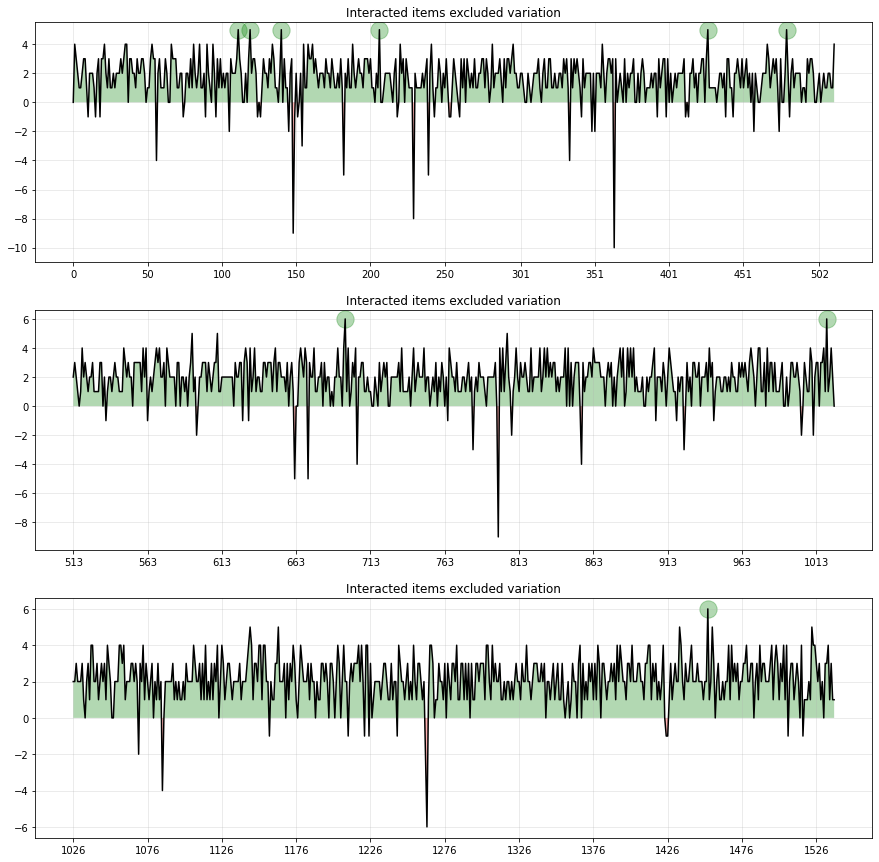

In [36]:
# instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["excluded_items_diff"] = (df["iitems_del_R"] - df["iitems_del_MSim"])

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["excluded_items_diff"]

plot_data(x, y, ax[0], "Interacted items excluded variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]

# del tmp_df['index']
# tmp_df.reset_index(inplace=True, drop=True)
# tmp_df.reset_index(inplace=True)

# separate x and y 
x = tmp_df['index']
y = tmp_df["excluded_items_diff"]

plot_data(x, y, ax[1], "Interacted items excluded variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]
# del tmp_df['index']
# tmp_df.reset_index(inplace=True, drop=True)
# tmp_df.reset_index(inplace=True)

# separate x and y 
x = tmp_df['index']
y = tmp_df["excluded_items_diff"]

plot_data(x, y, ax[2], "Interacted items excluded variation")

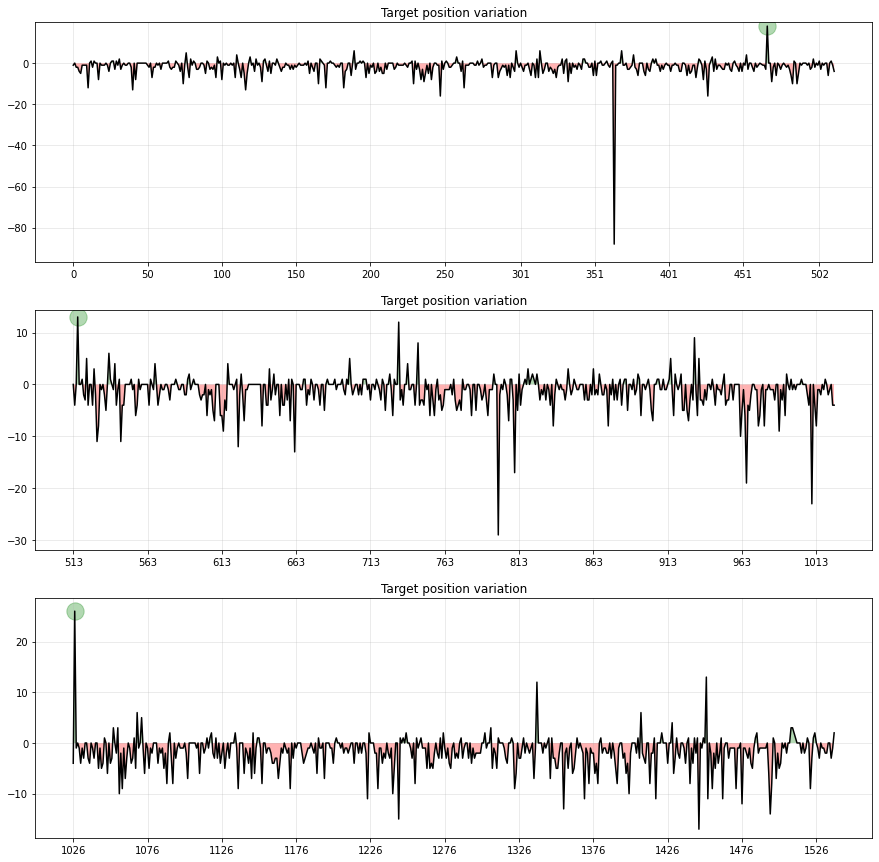

In [37]:
# instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["tpos_diff"] = (df["f_target_pos_R"] - df["f_target_pos_MSim"])

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y
x = tmp_df['index']
y = tmp_df["tpos_diff"]

plot_data(x, y, ax[0], "Target position variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["tpos_diff"]

plot_data(x, y, ax[1], "Target position variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["tpos_diff"]

plot_data(x, y, ax[2], "Target position variation")